In [ ]:
!pip install statsmodels --upgrade
!pip install timeseries-cv
!pip install pmdarima

#Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)
import datetime
# from statsmodels.tsa.ar_model import AutoReg
# import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from math import sqrt
# from tsxv.splitTrain import split_train_variableInput
from fbprophet import Prophet

#Importing Dataset

In [ ]:
df = pd.read_excel('New_Crude_All_manipulated.xlsx', sheet_name= 'Crude_All')
df.Date = pd.to_datetime(df.Date)
df.head()

Date  ...  Prev_quarter_WTI_price_PCH
0 2000-08-23  ...                     0.09025
1 2000-08-24  ...                     0.09025
2 2000-08-25  ...                     0.09025
3 2000-08-28  ...                     0.09025
4 2000-08-29  ...                     0.09025

[5 rows x 10 columns]

In [ ]:
df.shape

(5317, 10)

# Data Cleaning

Checking for any null values

In [ ]:
df.isnull().sum()

Date                             0
Open                           107
High                           107
Low                            107
Close                          107
Adj Close                      107
Volume                         107
Prev_quarter_GDP_PCH             0
Prev_quarter_inflation_rate      0
Prev_quarter_WTI_price_PCH       0
dtype: int64

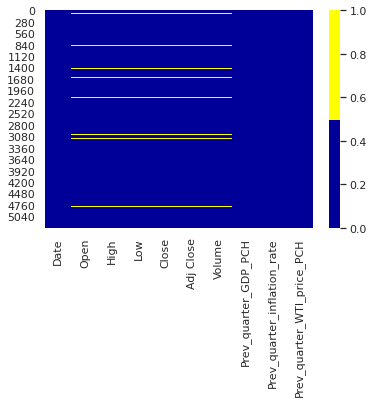

In [ ]:
cols = df.columns
colours = ['#000099', '#ffff00'] # specifying the colours -> yellow is for missing & blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours));

In [ ]:
df.fillna(method= 'ffill', axis= 0, inplace= True)

Adding Season,Year, Month, and Quarter column to the dataset-

In [ ]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'Spring': pd.date_range(start='01/03/'+year, end='31/05/'+year),
               'Summer': pd.date_range(start='01/06/'+year, end='31/08/'+year),
               'Autumn': pd.date_range(start='01/09/'+year, end='30/11/'+year)}
    if date in seasons['Spring']:
        return 'Spring'
    if date in seasons['Summer']:
        return 'Summer'
    if date in seasons['Autumn']:
        return 'Autumn'
    else:
        return 'Winter'

In [ ]:
df['Season'] = df.Date.map(season_of_date)
df['year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month_name()
df["Quarter"] = df.Date.dt.quarter
df["Quarter"]  = df["Quarter"].astype(str)
df["Quarter"] = df["Quarter"].apply(lambda x: 'Q'+x)
df['month_no'] = pd.DatetimeIndex(df['Date']).month
df['week_no'] = pd.DatetimeIndex(df['Date']).week
#df.set_index('Date', inplace= True)
df.head()

Date       Open       High  ...  Quarter  month_no  week_no
0 2000-08-23  31.950001  32.799999  ...       Q3         8       34
1 2000-08-24  31.900000  32.240002  ...       Q3         8       34
2 2000-08-25  31.700001  32.099998  ...       Q3         8       34
3 2000-08-28  32.040001  32.919998  ...       Q3         8       35
4 2000-08-29  32.820000  33.029999  ...       Q3         8       35

[5 rows x 16 columns]

In [ ]:
df.dtypes

Date                           datetime64[ns]
Open                                  float64
High                                  float64
Low                                   float64
Close                                 float64
Adj Close                             float64
Volume                                float64
Prev_quarter_GDP_PCH                  float64
Prev_quarter_inflation_rate           float64
Prev_quarter_WTI_price_PCH            float64
Season                                 object
year                                    int64
Month                                  object
Quarter                                object
month_no                                int64
week_no                                 int64
dtype: object

# Exploratory Data Analysis

##1) Adjusted Close

###Trend

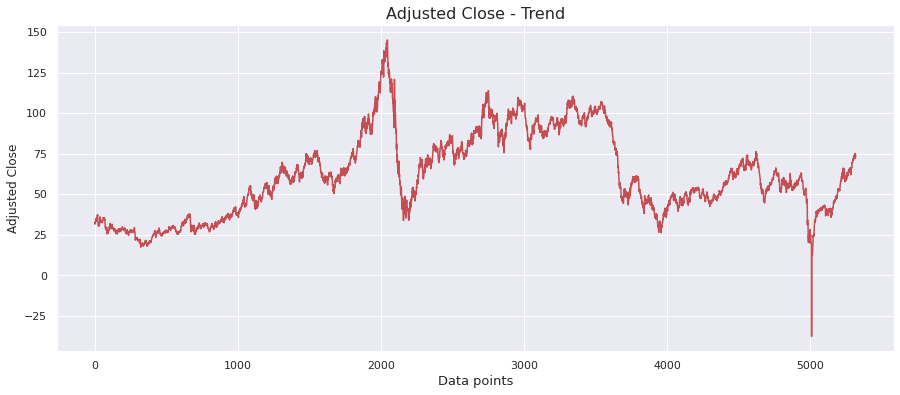

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15,6);
plt.plot(df['Adj Close'], 'r');
plt.title('Adjusted Close - Trend', fontsize=16);
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('Adjusted Close', fontsize=12);
plt.show();

###Dotted Plot

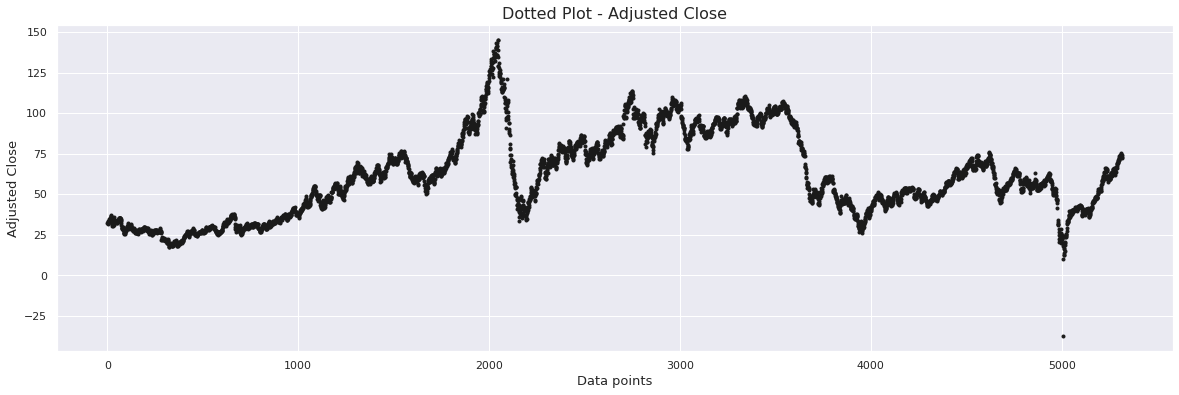

In [ ]:
fig = plt.gcf();
fig.set_size_inches(20,6);
df['Adj Close'].plot(style= 'k.');
plt.title('Dotted Plot - Adjusted Close', fontsize=16);
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('Adjusted Close', fontsize=13);
plt.show();

###Combination of plots -

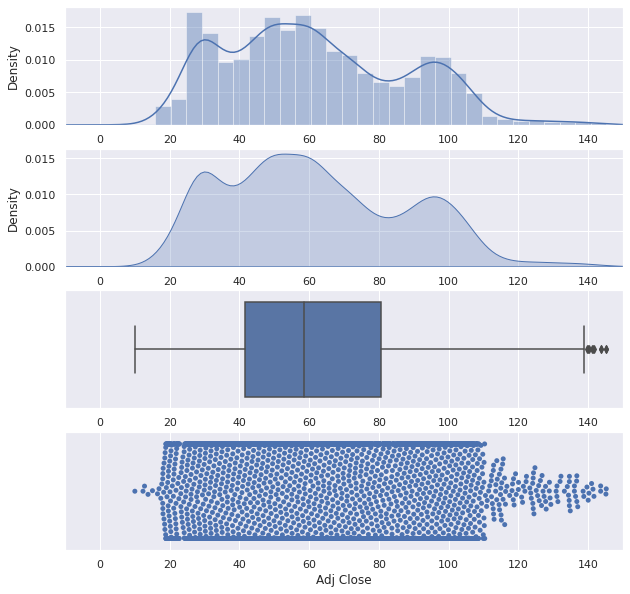

In [ ]:
fig, axs = plt.subplots(nrows= 4);
fig.set_size_inches(10,10);
p1 = sns.distplot(df['Adj Close'], ax= axs[0]);
p1.set(xlim=(-10,150));
p2 = sns.kdeplot(df['Adj Close'], shade=True, ax= axs[1]);
p2.set(xlim=(-10,150));
p3 = sns.boxplot(x = 'Adj Close', data= df, ax= axs[2]);
p3.set(xlim=(-10,150));
p4 = sns.swarmplot(x = 'Adj Close', data= df, ax= axs[3]);
p4.set(xlim=(-10,150));

###Line Plot

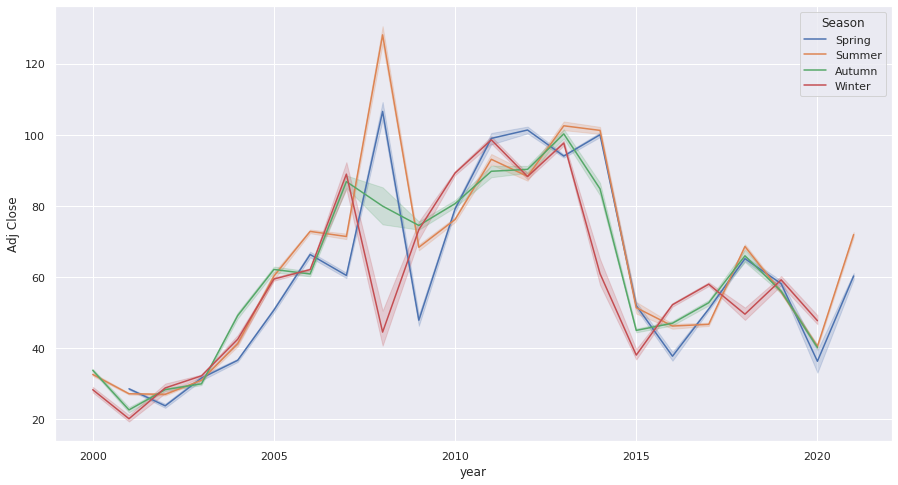

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15,8);
sns.lineplot(x= 'year', y= 'Adj Close', data= df, hue= 'Season', hue_order= ['Spring', 'Summer', 'Autumn', 'Winter']);

###Lag Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


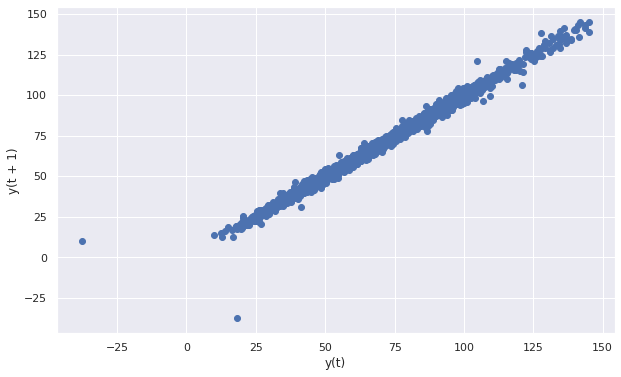

In [ ]:
from pandas.plotting import lag_plot
fig = plt.gcf();
fig.set_size_inches(10,6);
lag_plot(df['Adj Close']);

##2) Volume

###Trend

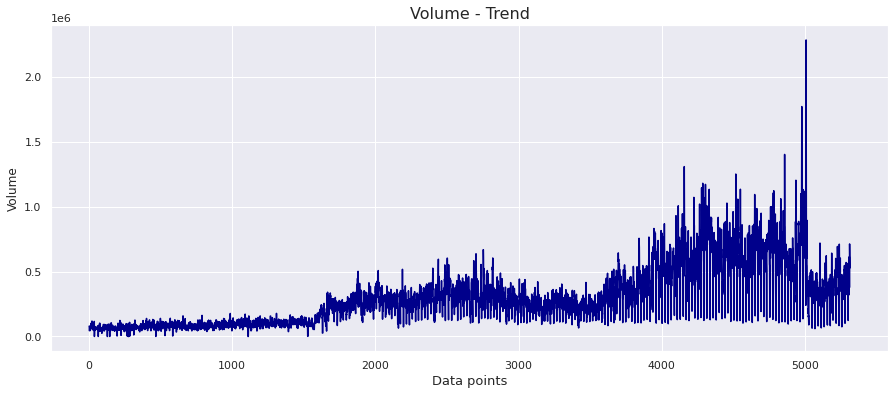

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15,6);
plt.plot(df['Volume'], 'darkblue');
plt.title('Volume - Trend', fontsize=16);
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('Volume', fontsize=12);
plt.show();

###Dotted Plot

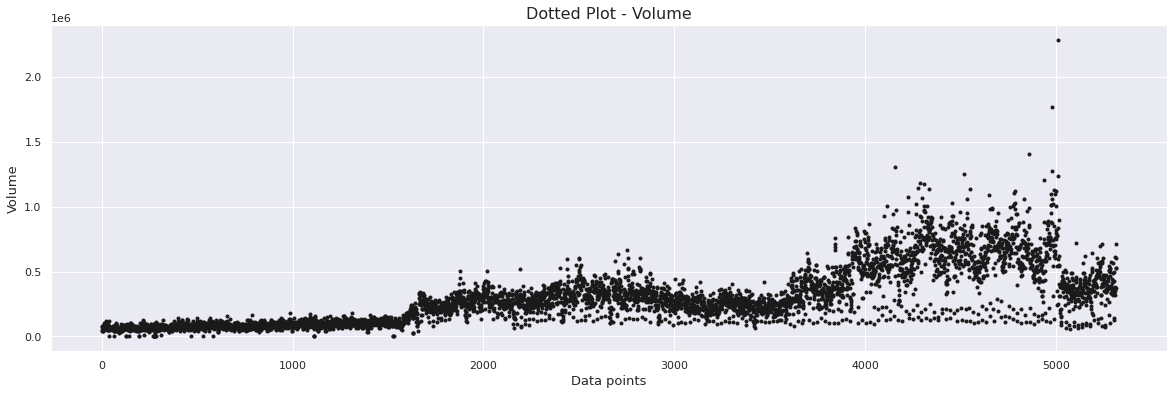

In [ ]:
fig = plt.gcf();
fig.set_size_inches(20,6);
df['Volume'].plot(style= 'k.');
plt.title('Dotted Plot - Volume', fontsize=16);
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('Volume', fontsize=13);
plt.show();

###Combination of plots

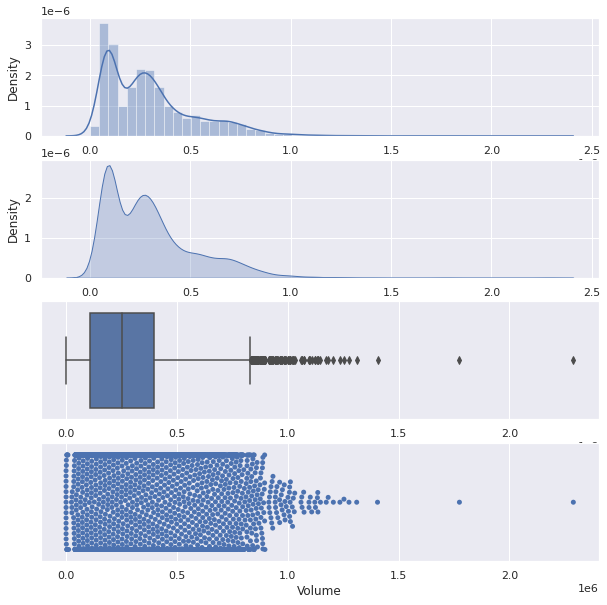

In [ ]:
fig, axs = plt.subplots(nrows= 4);
fig.set_size_inches(10,10);
sns.distplot(df['Volume'], ax= axs[0]);
sns.kdeplot(df['Volume'], shade=True, ax= axs[1]);
sns.boxplot(x = 'Volume', data= df, ax= axs[2]);
sns.swarmplot(x = 'Volume', data= df, ax= axs[3]);

###Line Plot

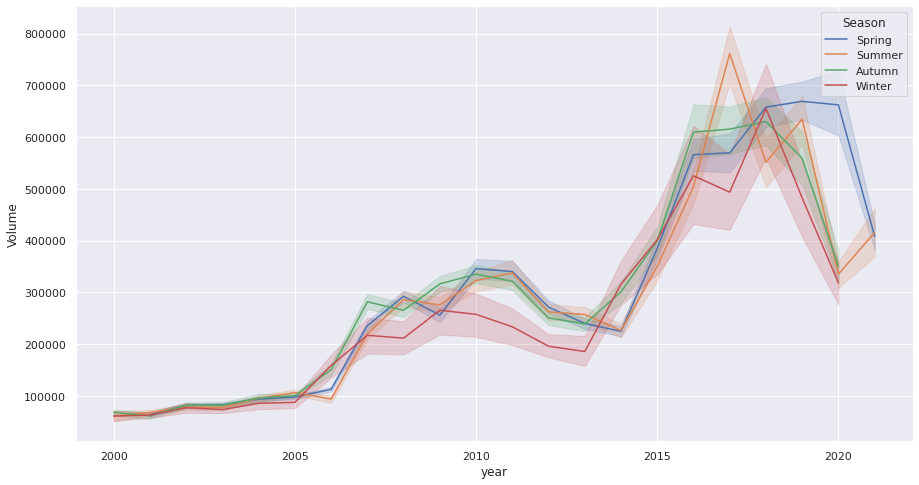

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15,8);
sns.lineplot(x= 'year', y= 'Volume', data= df, hue= 'Season', hue_order= ['Spring', 'Summer', 'Autumn', 'Winter']);

###Lag Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


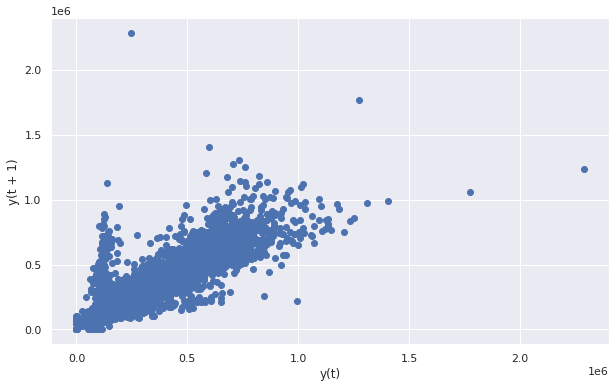

In [ ]:
fig = plt.gcf();
fig.set_size_inches(10,6);
lag_plot(df['Volume']);

##3) Open

###Trend

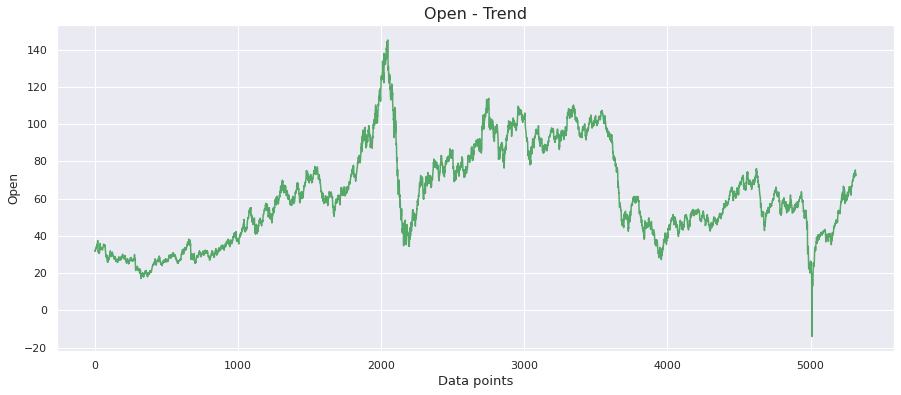

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15,6);
plt.plot(df['Open'], 'g');
plt.title('Open - Trend', fontsize=16);
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('Open', fontsize=12);
plt.show();

###Dotted Plot

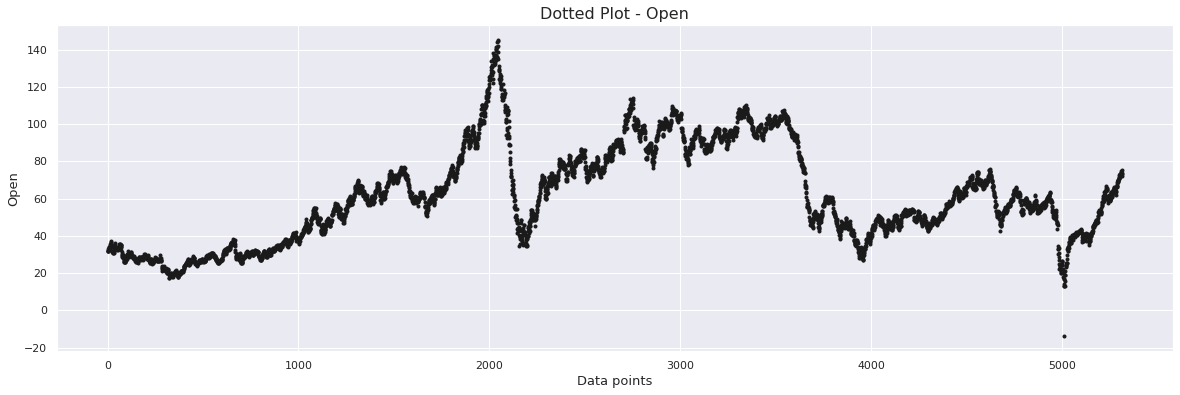

In [ ]:
fig = plt.gcf();
fig.set_size_inches(20,6);
df['Open'].plot(style= 'k.');
plt.title('Dotted Plot - Open', fontsize=16);
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('Open', fontsize=13);
plt.show();

###Combination of plots-

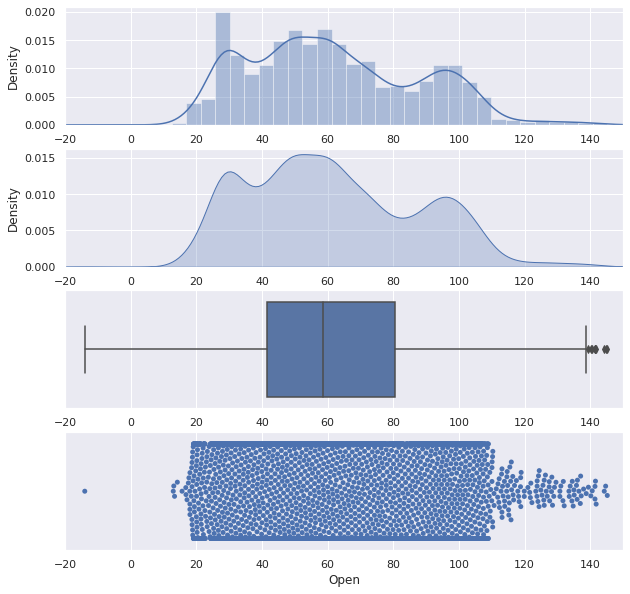

In [ ]:
fig, axs = plt.subplots(nrows= 4);
fig.set_size_inches(10,10);
p1 = sns.distplot(df['Open'], ax= axs[0]);
p1.set(xlim=(-20,150));
p2 = sns.kdeplot(df['Open'], shade=True, ax= axs[1]);
p2.set(xlim=(-20,150));
p3 = sns.boxplot(x = 'Open', data= df, ax= axs[2]);
p3.set(xlim=(-20,150));
p4 = sns.swarmplot(x = 'Open', data= df, ax= axs[3]);
p4.set(xlim=(-20,150));

###Line PLot

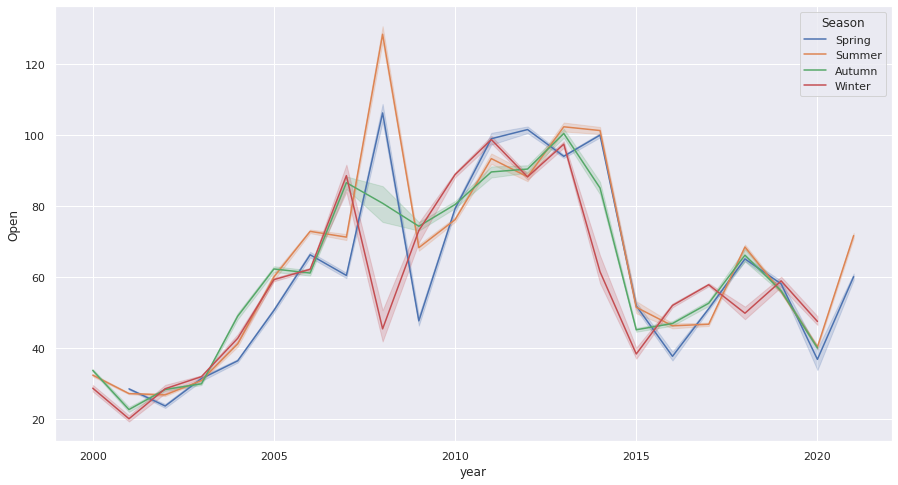

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15,8);
sns.lineplot(x= 'year', y= 'Open', data= df, hue= 'Season', hue_order= ['Spring', 'Summer', 'Autumn', 'Winter']);

###Lag Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


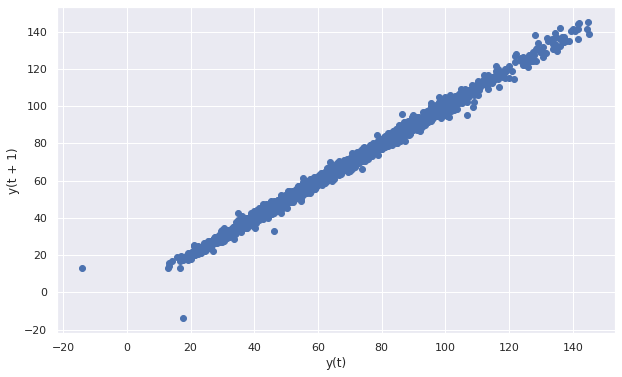

In [ ]:
fig = plt.gcf();
fig.set_size_inches(10,6);
lag_plot(df['Open']);

##4) High

###Trend

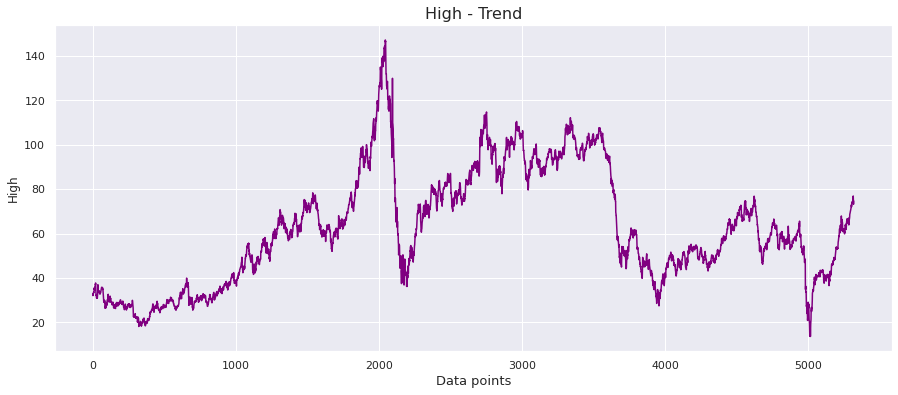

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15,6);
plt.plot(df['High'], 'purple');
plt.title('High - Trend', fontsize=16);
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('High', fontsize=12);
plt.show();

###Dotted Plot

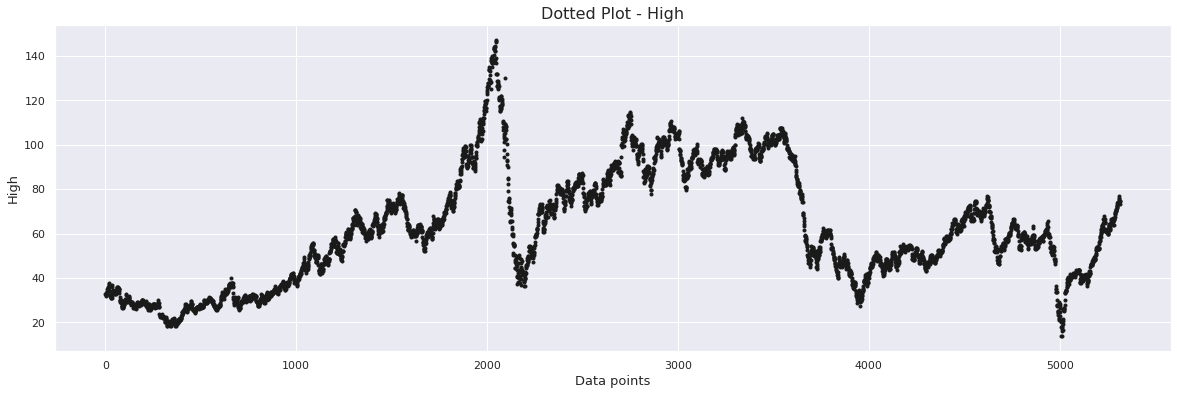

In [ ]:
fig = plt.gcf();
fig.set_size_inches(20,6);
df['High'].plot(style= 'k.');
plt.title('Dotted Plot - High', fontsize=16);
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('High', fontsize=13);
plt.show();

###Combination of plots

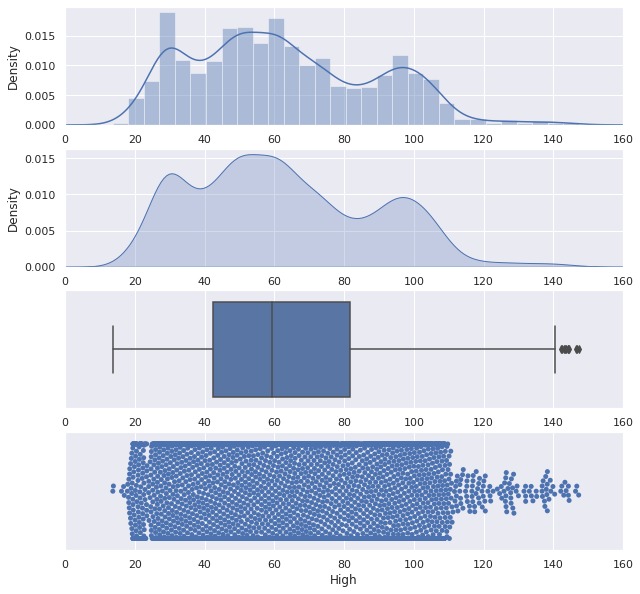

In [ ]:
fig, axs = plt.subplots(nrows= 4);
fig.set_size_inches(10,10);
p1 = sns.distplot(df['High'], ax= axs[0]);
p1.set(xlim=(0,160));
p2 = sns.kdeplot(df['High'], shade=True, ax= axs[1]);
p2.set(xlim=(0,160));
p3 = sns.boxplot(x = 'High', data= df, ax= axs[2]);
p3.set(xlim=(0,160));
p4 = sns.swarmplot(x = 'High', data= df, ax= axs[3]);
p4.set(xlim=(0,160));

###Line Plot

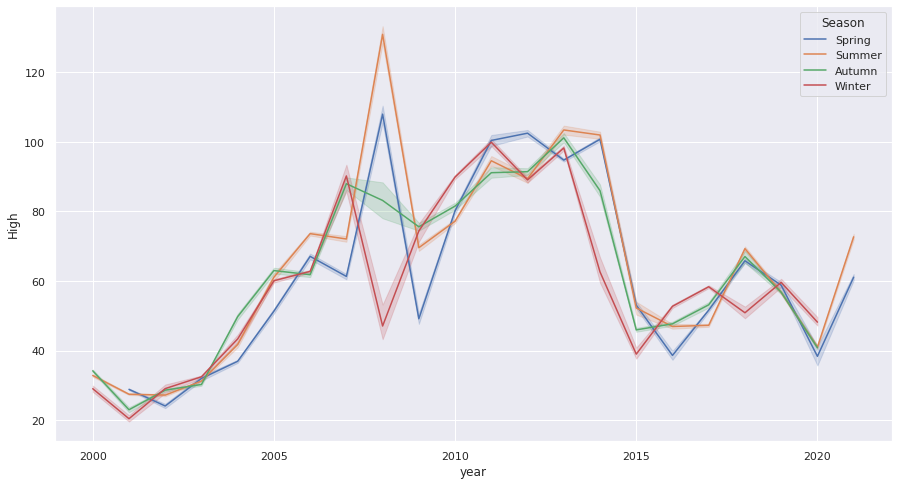

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15,8);
sns.lineplot(x= 'year', y= 'High', data= df, hue= 'Season', hue_order= ['Spring', 'Summer', 'Autumn', 'Winter']);

###Lag Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


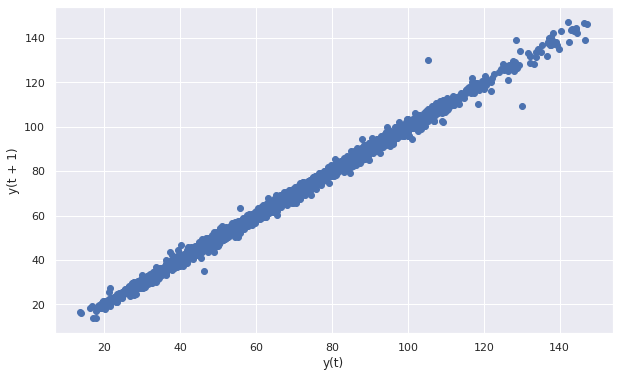

In [ ]:
fig = plt.gcf();
fig.set_size_inches(10,6);
lag_plot(df['High']);

##5) Low

###Trend

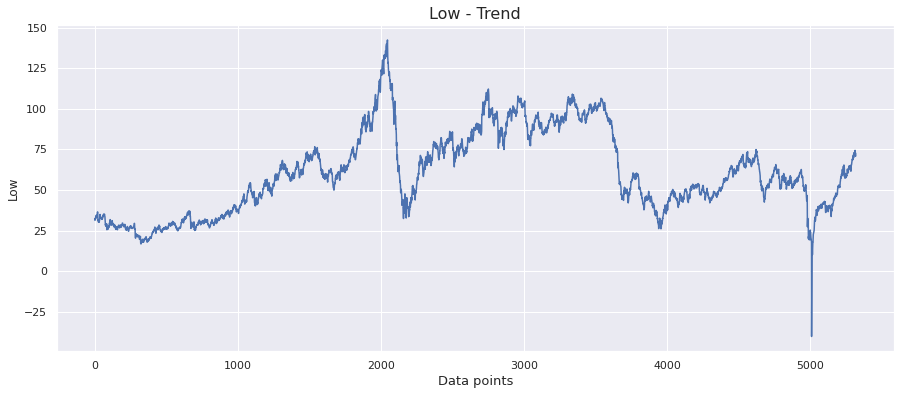

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15,6);
plt.plot(df['Low'], 'b');
plt.title('Low - Trend', fontsize=16);
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('Low', fontsize=12);
plt.show();

###Dotted Plot

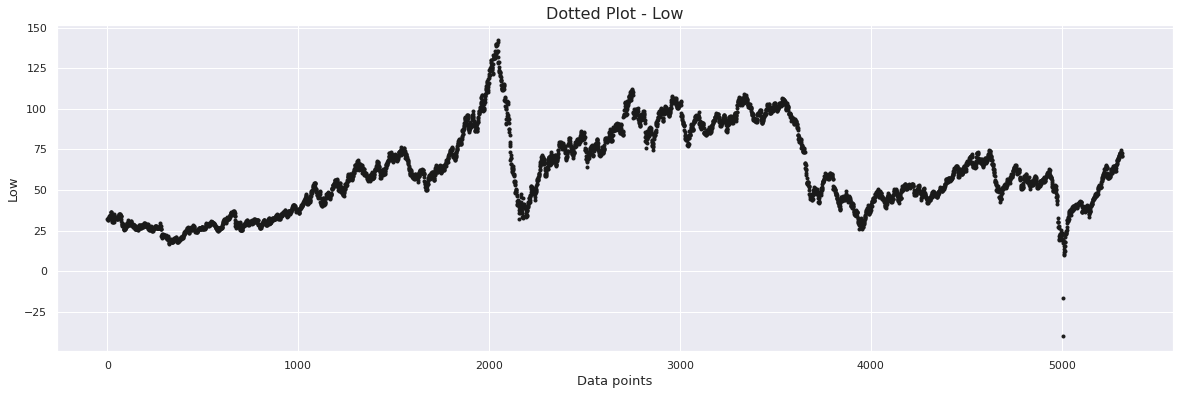

In [ ]:
fig = plt.gcf();
fig.set_size_inches(20,6);
df['Low'].plot(style= 'k.');
plt.title('Dotted Plot - Low', fontsize=16);
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('Low', fontsize=13);
plt.show();

###Combination of plots

[(-10.0, 160.0)]

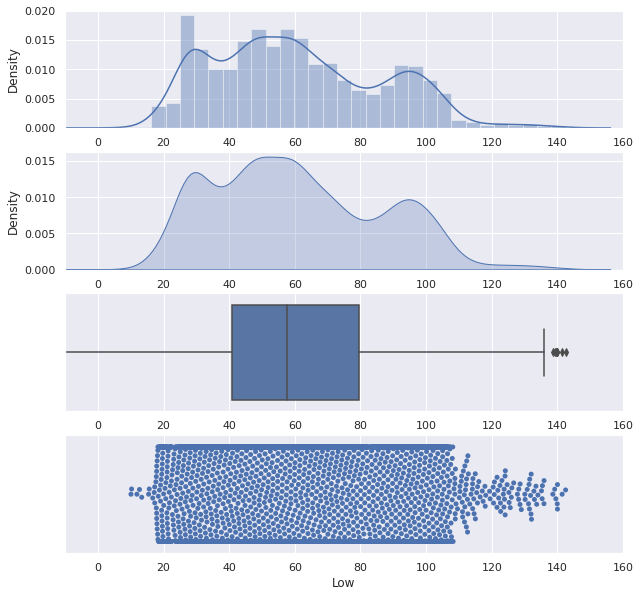

In [ ]:
fig, axs = plt.subplots(nrows= 4);
fig.set_size_inches(10,10);
p1 = sns.distplot(df['Low'], ax= axs[0]);
p1.set(xlim= (-10,160))
p2 = sns.kdeplot(df['Low'], shade=True, ax= axs[1]);
p2.set(xlim= (-10,160))
p3 = sns.boxplot(x = 'Low', data= df, ax= axs[2]);
p3.set(xlim= (-10,160))
p4 = sns.swarmplot(x = 'Low', data= df, ax= axs[3]);
p4.set(xlim= (-10,160))

###Line Plot

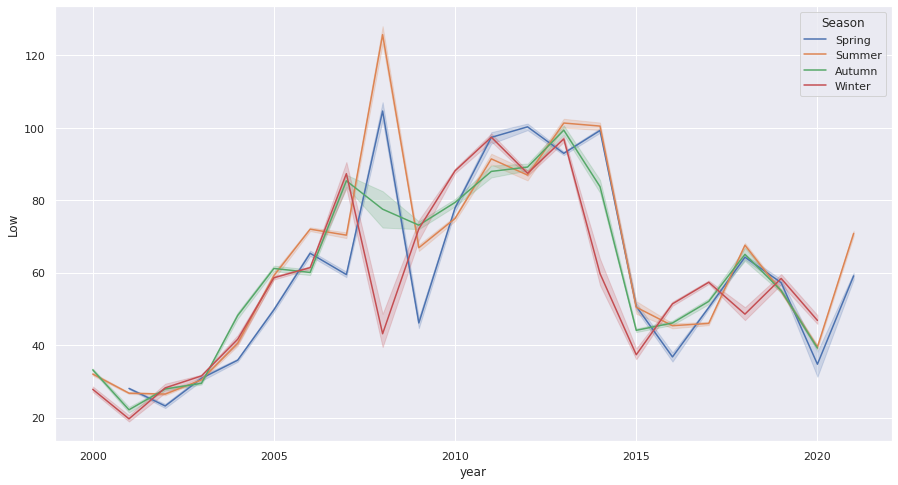

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15,8);
sns.lineplot(x= 'year', y= 'Low', data= df, hue= 'Season', hue_order= ['Spring', 'Summer', 'Autumn', 'Winter']);

###Lag Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


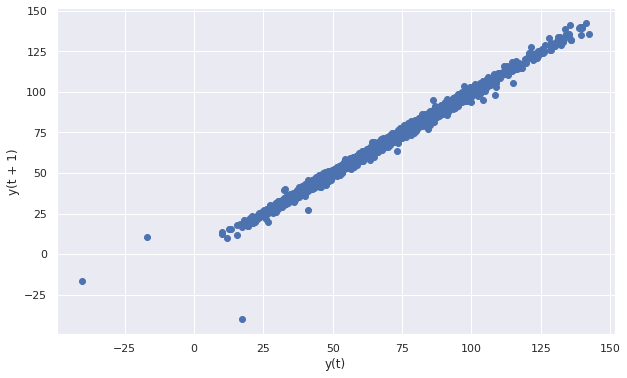

In [ ]:
fig = plt.gcf();
fig.set_size_inches(10,6);
lag_plot(df['Low']);

##Some other visualizations

###PRICE

####Close and Adjusted Close

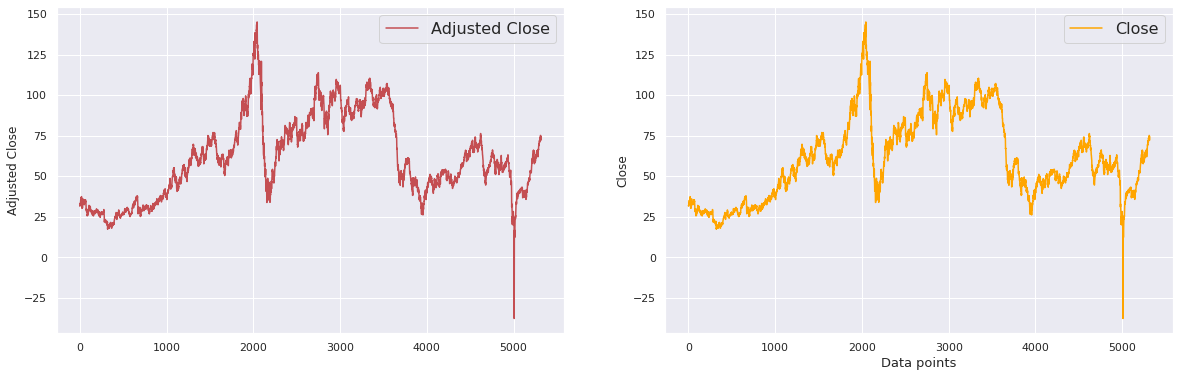

In [ ]:
fig = plt.gcf();
fig.set_size_inches(20,6);
plt.subplot(1,2,1);
plt.plot(df['Adj Close'], 'r', label= "Adjusted Close");
plt.ylabel('Adjusted Close', fontsize=12);
plt.legend(fontsize= 16)
# plt.show();

fig = plt.gcf();
fig.set_size_inches(20,6);
plt.subplot(1,2,2);
plt.plot(df['Close'], 'orange', label= 'Close');
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('Close', fontsize=12);
plt.legend(fontsize = 16);
plt.show();

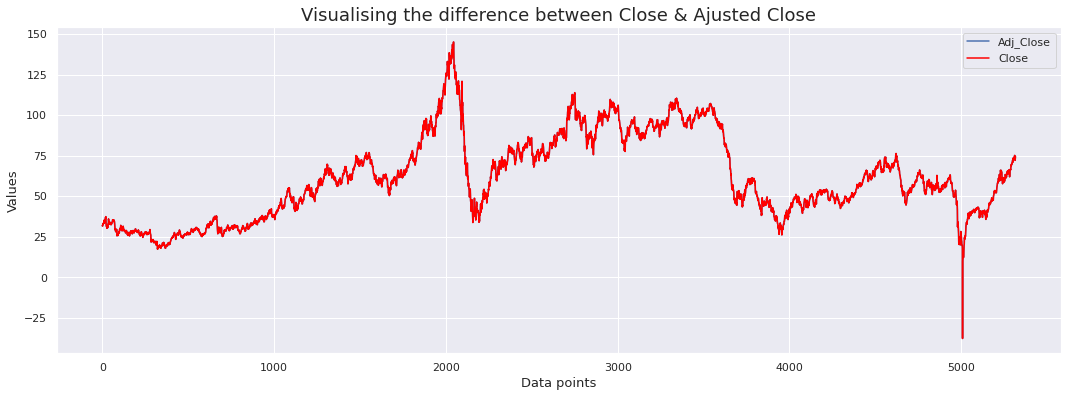

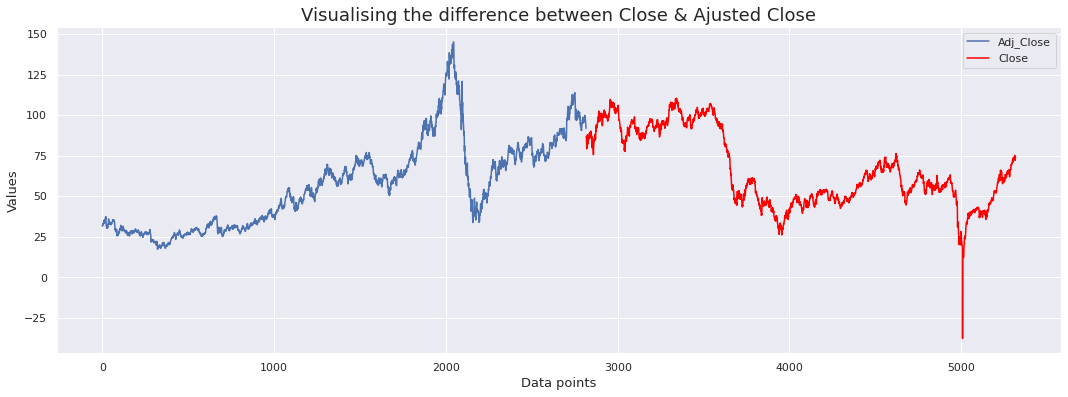

In [ ]:
plt.figure(figsize=(18,6));
plt.plot(df['Adj Close'],label="Adj_Close");
plt.plot(df['Close'], color='red',label='Close');
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('Values', fontsize= 13);
plt.title('Visualising the difference between Close & Ajusted Close', fontsize= 18);
plt.legend();

plt.figure(figsize=(18,6));
plt.plot(df['Adj Close'][:-2500],label="Adj_Close");
plt.plot(df['Close'][-2500:], color='red',label='Close');
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('Values', fontsize= 13);
plt.title('Visualising the difference between Close & Ajusted Close', fontsize= 18);
plt.legend();

####Yearly change in the price

In [ ]:
!pip3 install plotly_express

In [ ]:
import plotly_express as px

In [ ]:
df1 = df.copy()
df1['Adjusted_Close'] = abs(df1['Adj Close'])

In [ ]:
fig = px.scatter(df1, x= 'year', y= 'Adjusted_Close', size = 'Adjusted_Close', animation_frame= 'year', animation_group= "year",
           range_y= [-40,160], range_x= [1999,2022])
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000
fig.show()

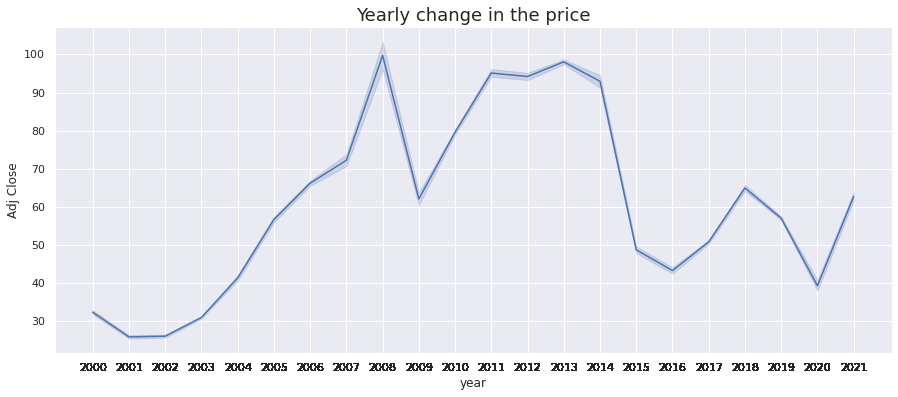

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15, 6);
sns.lineplot(x= 'year', y= 'Adj Close', data= df);
plt.xticks(ticks= df['year']);
plt.title('Yearly change in the price', fontsize= 18);

####Quarterly change in price

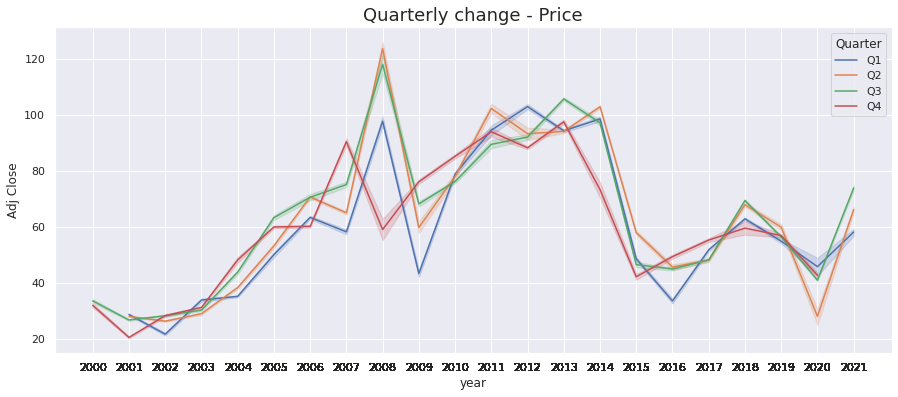

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15, 6);
sns.lineplot(x= 'year', y= 'Adj Close', data= df, hue= 'Quarter', hue_order= ['Q1','Q2','Q3','Q4']);
plt.xticks(ticks= df['year']);
plt.title('Quarterly change - Price', fontsize= 18);
plt.show();

In [ ]:
px.scatter(df1, x= 'year', y= 'Adjusted_Close',size='Adjusted_Close', animation_frame= 'year', animation_group= "Quarter", color= 'Quarter',
           range_y= [-40,160], range_x= [1999,2022])

####Monthly change in price

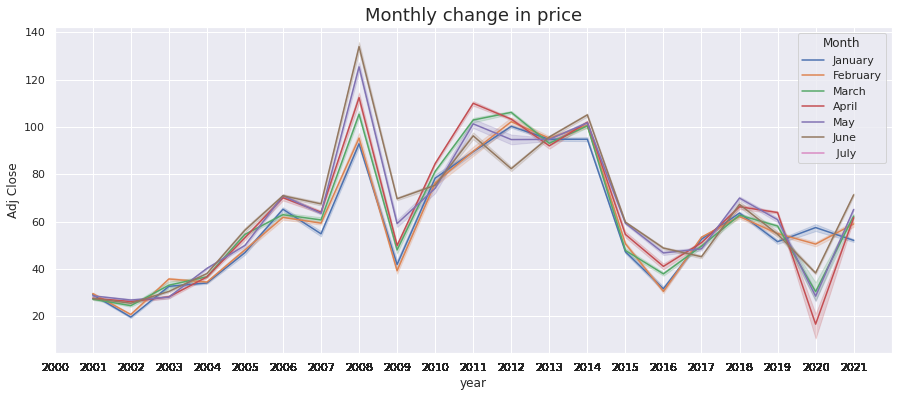

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15, 6);
sns.lineplot(x= 'year', y= 'Adj Close', data= df, hue= 'Month', hue_order= ['January', 'February', 'March', 'April', 'May', 'June',' July']);
plt.xticks(ticks= df['year']);
plt.title('Monthly change in price', fontsize= 18);
plt.show();

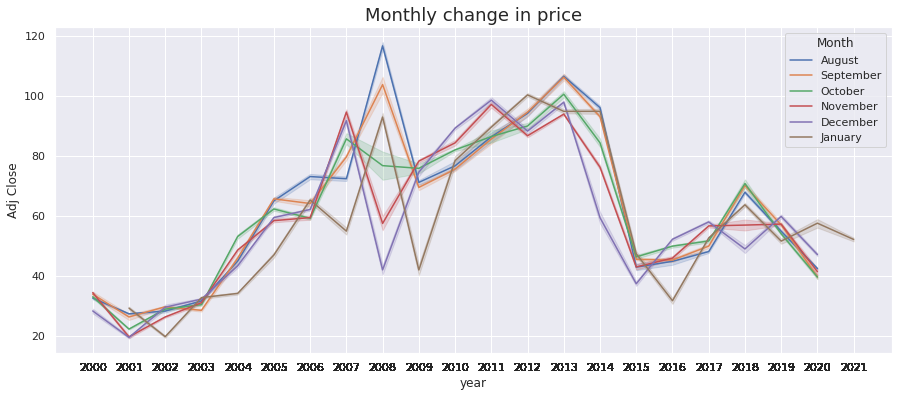

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15, 6);
sns.lineplot(x= 'year', y= 'Adj Close', data= df, hue= 'Month', hue_order= ['August', 'September', 'October', 'November', 'December', 'January']);
plt.xticks(ticks= df['year']);
plt.title('Monthly change in price', fontsize= 18);

In [ ]:
px.scatter(df1, x= 'year', y= 'Adjusted_Close',size='Adjusted_Close', animation_frame= 'year', animation_group= "Month", color= 'Month',
           range_y= [-40,160], range_x= [1999,2022])

####Seasonal change in the price

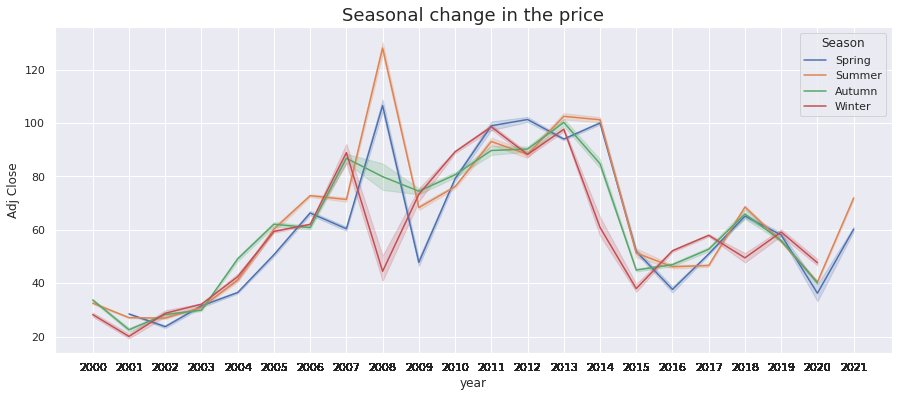

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15, 6);
sns.lineplot(x= 'year', y= 'Adj Close', data= df, hue= 'Season', hue_order= ['Spring', 'Summer', 'Autumn', 'Winter']);
plt.xticks(ticks= df['year']);
plt.title('Seasonal change in the price', fontsize= 18);
plt.show();

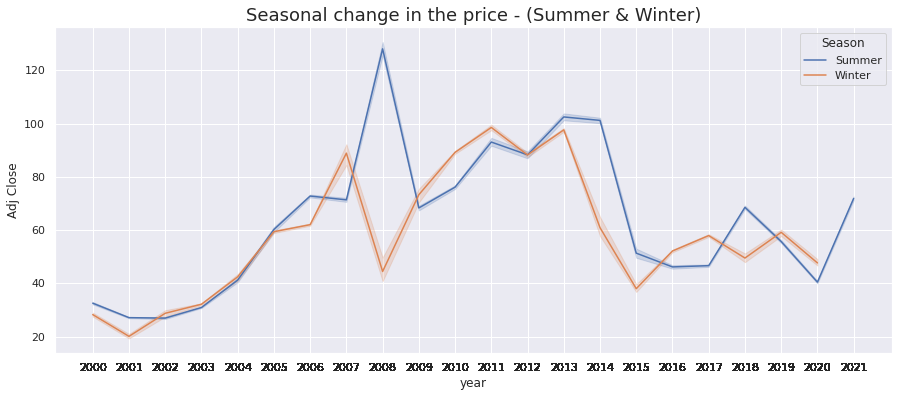

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15, 6);
sns.lineplot(x= 'year', y= 'Adj Close', data= df, hue= 'Season', hue_order= ['Summer','Winter']);
plt.xticks(ticks= df['year']);
plt.title('Seasonal change in the price - (Summer & Winter)', fontsize= 18);

In [ ]:
px.scatter(df1, x= 'year', y= 'Adjusted_Close', size='Adjusted_Close', animation_frame= 'year', animation_group= "Season", color= 'Season',
           range_y= [-40,160], range_x= [1999,2022])

###Ninety days returns (Aggregated Monthly)

In [ ]:
df_ = pd.read_excel('New_Crude_All_manipulated.xlsx', sheet_name= 'Crude_All')
df_.Date = pd.to_datetime(df_.Date)
df_.fillna(method= 'ffill', axis= 0, inplace= True)

In [ ]:
x = np.arange(90, 5317)
y = np.arange(5317)
ninety_days_return = []
for i,j in zip(x,y):
    res = ((df_['Close'][i] - df_['Close'][j]) / df_['Close'][j])*100
    ninety_days_return.append(round(res,4))
df_.drop(df_.tail(90).index, axis=0, inplace= True)
df_['ninety_days_return'] = ninety_days_return

In [ ]:
#resample month wise
df_.set_index(df_['Date'], inplace= True)
df_ = df_.resample('M').mean()
df_.head()

Open  ...  ninety_days_return
Date                   ...                    
2000-08-31  32.344286  ...          -16.940757
2000-09-30  33.841429  ...          -12.200819
2000-10-31  32.992727  ...          -11.056277
2000-11-30  34.238637  ...          -21.385323
2000-12-31  28.670952  ...           -0.414529

[5 rows x 10 columns]

In [ ]:
df_['year'] = pd.DatetimeIndex(df_.index).year
df_['Month'] = pd.DatetimeIndex(df_.index).month_name()
df_["Quarter"] = df_.index.quarter
df_["Quarter"]  = df_["Quarter"].astype(str)
df_["Quarter"] = df_["Quarter"].apply(lambda x: 'Q'+x)
df_['Season'] = df_.index.map(season_of_date)
# df_["Date"] = df_.index

In [ ]:
df_.head()

Open       High        Low  ...      Month  Quarter  Season
Date                                         ...                            
2000-08-31  32.344286  32.884286  32.022857  ...     August       Q3  Summer
2000-09-30  33.841429  34.496667  33.258095  ...  September       Q3  Autumn
2000-10-31  32.992727  33.470454  32.455909  ...    October       Q4  Autumn
2000-11-30  34.238637  34.742727  33.866818  ...   November       Q4  Autumn
2000-12-31  28.670952  29.090952  27.809048  ...   December       Q4  Winter

[5 rows x 14 columns]

Ninety days returns aggregated monthly.

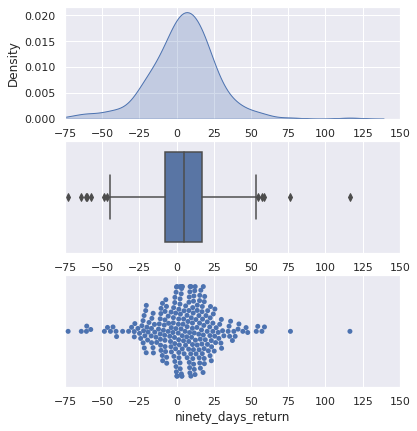

In [ ]:
fig, axs = plt.subplots(nrows= 3);
fig.set_size_inches(6,7);
p1 = sns.kdeplot(df_['ninety_days_return'], shade=True, ax= axs[0]);
p1.set(xlim=(-75,150));
p2 = sns.boxplot(df_['ninety_days_return'], data= df_, ax= axs[1]);
p2.set(xlim=(-75,150));
p3 = sns.swarmplot(df_['ninety_days_return'], data= df_, ax= axs[2]);
p3.set(xlim=(-75,150));

GDP Percentage change from previous period.

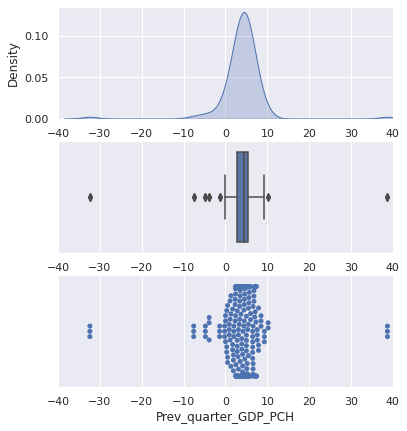

In [ ]:
fig, axs = plt.subplots(nrows= 3);
fig.set_size_inches(6,7);
p1 = sns.kdeplot(df_['Prev_quarter_GDP_PCH'], shade=True, ax= axs[0]);
p1.set(xlim=(-40,40));
p2 = sns.boxplot(df_['Prev_quarter_GDP_PCH'], data= df_, ax= axs[1]);
p2.set(xlim=(-40,40));
p3 = sns.swarmplot(df_['Prev_quarter_GDP_PCH'], data= df_, ax= axs[2]);
p3.set(xlim=(-40,40));

Inflation rate

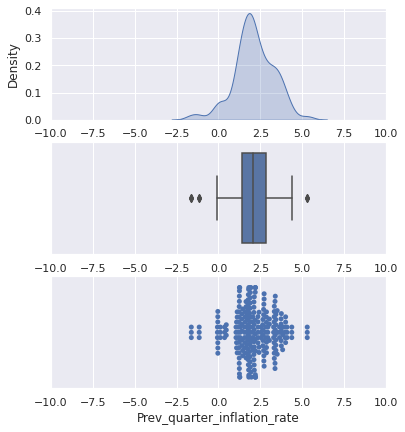

In [ ]:
fig, axs = plt.subplots(nrows= 3);
fig.set_size_inches(6,7);
p1 = sns.kdeplot(df_['Prev_quarter_inflation_rate'], shade=True, ax= axs[0]);
p1.set(xlim=(-10,10));
p2 = sns.boxplot(df_['Prev_quarter_inflation_rate'], data= df_, ax= axs[1]);
p2.set(xlim=(-10,10));
p3 = sns.swarmplot(df_['Prev_quarter_inflation_rate'], data= df_, ax= axs[2]);
p3.set(xlim=(-10,10));

WTI prices

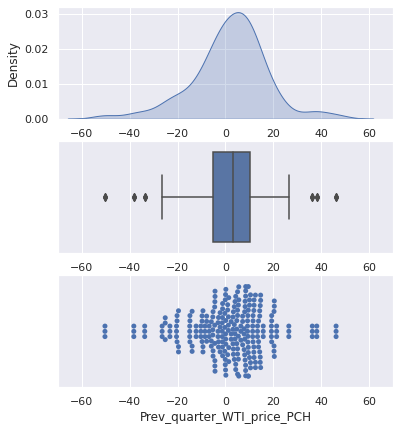

In [ ]:
fig, axs = plt.subplots(nrows= 3);
fig.set_size_inches(6,7);
p1 = sns.kdeplot(df_['Prev_quarter_WTI_price_PCH'], shade=True, ax= axs[0]);
p1.set(xlim=(-70,70));
p2 = sns.boxplot(df_['Prev_quarter_WTI_price_PCH'], data= df_, ax= axs[1]);
p2.set(xlim=(-70,70));
p3 = sns.swarmplot(df_['Prev_quarter_WTI_price_PCH'], data= df_, ax= axs[2]);
p3.set(xlim=(-70,70));

####Yearly change in returns

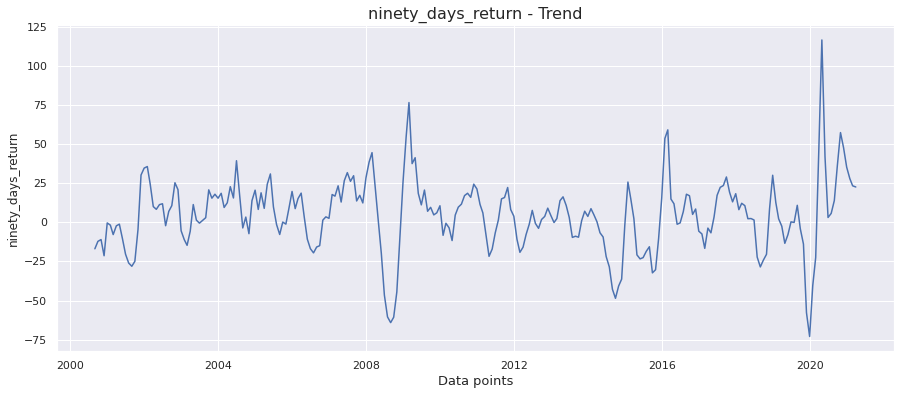

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15,6);
plt.plot(df_['ninety_days_return']);
plt.title('ninety_days_return - Trend', fontsize=16);
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('ninety_days_return', fontsize=12);
plt.show();

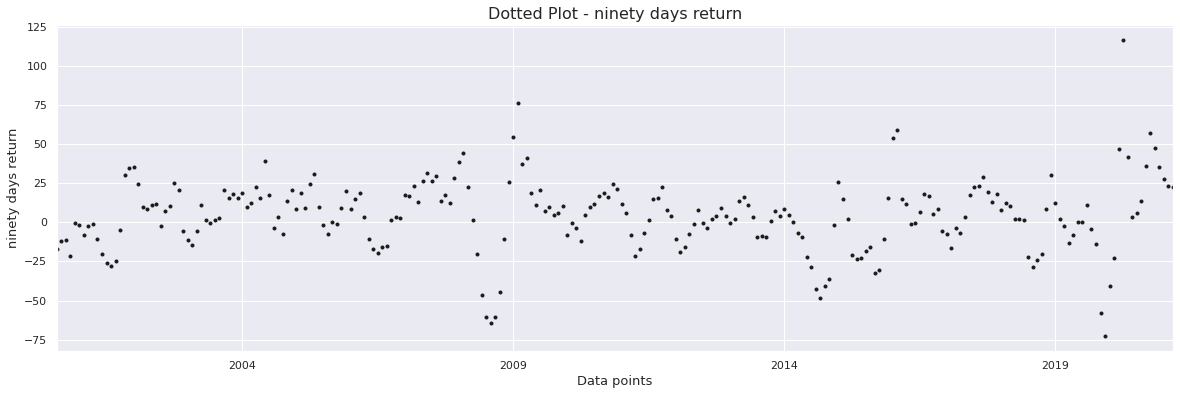

In [ ]:
fig = plt.gcf();
fig.set_size_inches(20,6);
df_['ninety_days_return'].plot(style= 'k.');
plt.title('Dotted Plot - ninety days return', fontsize=16);
plt.xlabel('Data points', fontsize= 13);
plt.ylabel('ninety days return', fontsize=13);
plt.show();

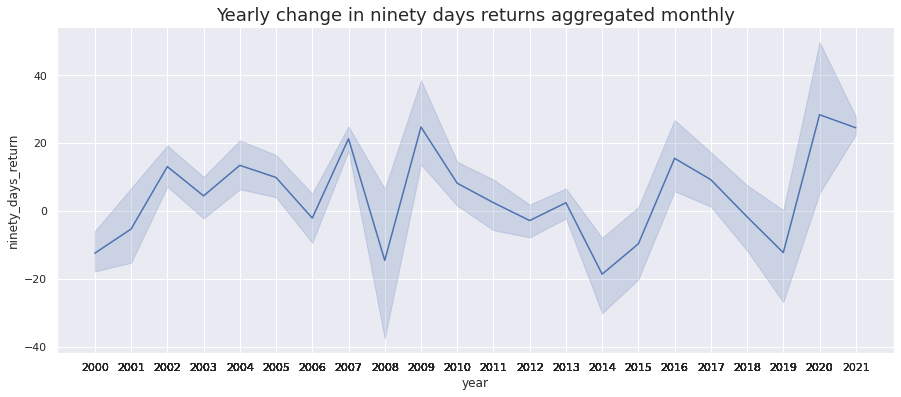

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15, 6);
sns.lineplot(x= 'year', y= 'ninety_days_return', data= df_);
plt.xticks(ticks= df_['year']);
plt.title('Yearly change in ninety days returns aggregated monthly', fontsize= 18);

####Quarterly change in returns

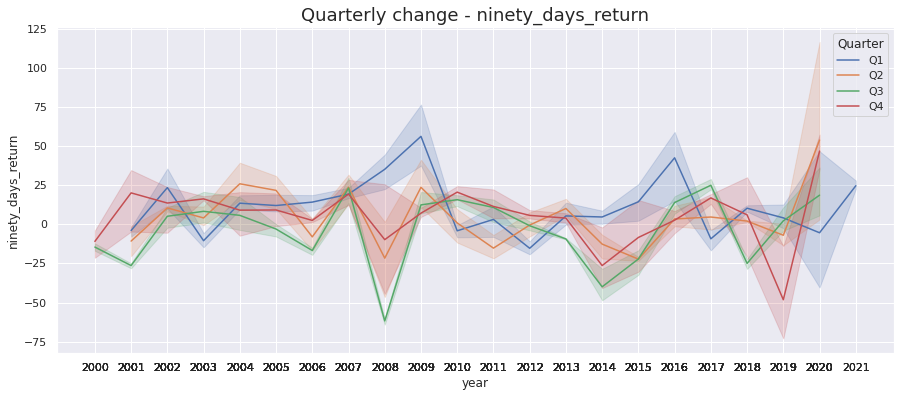

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15, 6);
sns.lineplot(x= 'year', y= 'ninety_days_return', data= df_, hue= 'Quarter', hue_order= ['Q1','Q2','Q3','Q4']);
plt.xticks(ticks= df_['year']);
plt.title('Quarterly change - ninety_days_return', fontsize= 18);
plt.show();

####Monthly change in returns

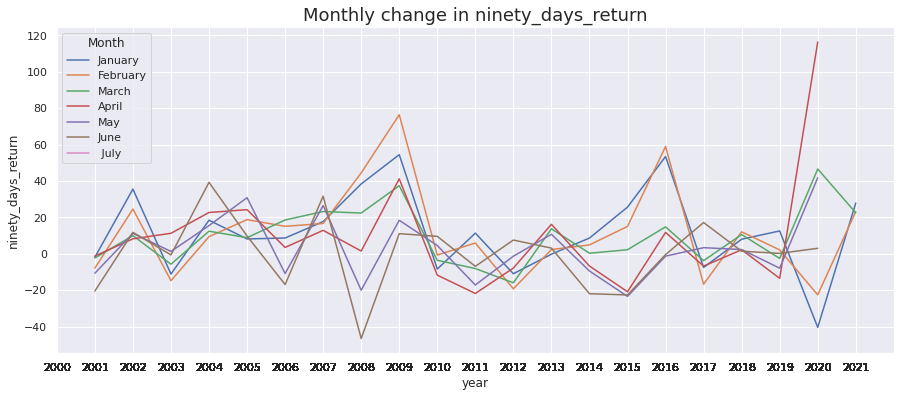

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15, 6);
sns.lineplot(x= 'year', y= 'ninety_days_return', data= df_, hue= 'Month', hue_order= ['January', 'February', 'March', 'April', 'May', 'June',' July']);
plt.xticks(ticks= df['year']);
plt.title('Monthly change in ninety_days_return', fontsize= 18);
plt.show();

####Seasonal Change in returns

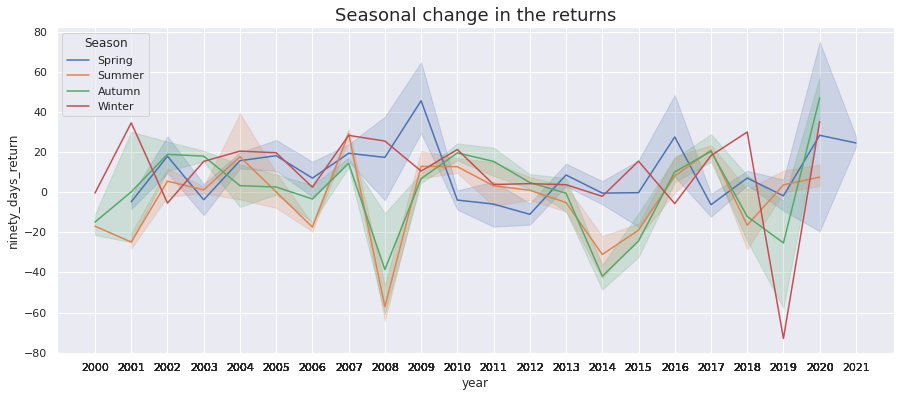

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15, 6);
sns.lineplot(x= 'year', y= 'ninety_days_return', data= df_, hue= 'Season', hue_order= ['Spring', 'Summer', 'Autumn', 'Winter']);
plt.xticks(ticks= df_['year']);
plt.title('Seasonal change in the returns', fontsize= 18);
plt.show();

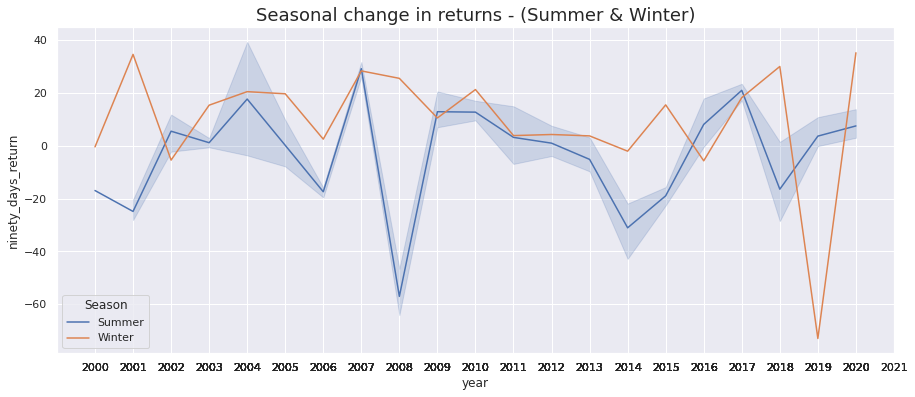

In [ ]:
fig = plt.gcf();
fig.set_size_inches(15, 6);
sns.lineplot(x= 'year', y= 'ninety_days_return', data= df_, hue= 'Season', hue_order= ['Summer','Winter']);
plt.xticks(ticks= df_['year']);
plt.title('Seasonal change in returns - (Summer & Winter)', fontsize= 18);

#Model Building

##AR Algorithm (Auto Regression)

In [ ]:
df1 = pd.read_excel('New_Crude_All_manipulated.xlsx', sheet_name= 'Crude_All')
df1.Date = pd.to_datetime(df1.Date)
df1.fillna(method= 'ffill', axis= 0, inplace= True)

In [ ]:
#treating the outlier
df1['Close'][5008] = df1['Close'][5007]    

In [ ]:
x = np.arange(90, 5317)
y = np.arange(5317)
ninety_days_return = []
for i,j in zip(x,y):
    res = ((df1['Close'][i] - df1['Close'][j]) / df1['Close'][j])*100
    ninety_days_return.append(round(res,4))

In [ ]:
df1.drop(df1.tail(90).index, axis=0, inplace= True)
df1['ninety_days_return'] = ninety_days_return

In [ ]:
df1.drop(columns= ['Open','Low','Adj Close','Close','High','Volume', 'Prev_quarter_GDP_PCH', 'Prev_quarter_inflation_rate', 'Prev_quarter_WTI_price_PCH'],axis= 1, inplace= True)
df1.set_index('Date', inplace= True)
df1.head()

ninety_days_return
Date                          
2000-08-23            -17.4727
2000-08-24            -18.2738
2000-08-25            -16.3807
2000-08-28            -18.4667
2000-08-29            -16.8704

In [ ]:
df1 = df1.resample('M').mean()
df1.head()

ninety_days_return
Date                          
2000-08-31          -16.940757
2000-09-30          -12.200819
2000-10-31          -11.056277
2000-11-30          -21.385323
2000-12-31           -0.414529

In [ ]:
df1.tail()

ninety_days_return
Date                          
2020-11-30           47.736415
2020-12-31           35.212295
2021-01-31           27.910395
2021-02-28           23.287026
2021-03-31           22.535100

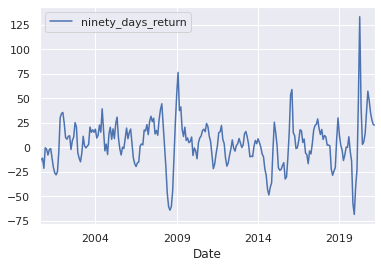

In [ ]:
df1.plot();

###Check for stationarity

In [ ]:
# Dickey fuller test
from statsmodels.tsa.stattools import adfuller

def adfuller_test(a):
    result=adfuller(a)
    labels = ['p-value']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(df1['ninety_days_return'])

p-value : -5.787479282703523
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


###Figure out order of model-

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

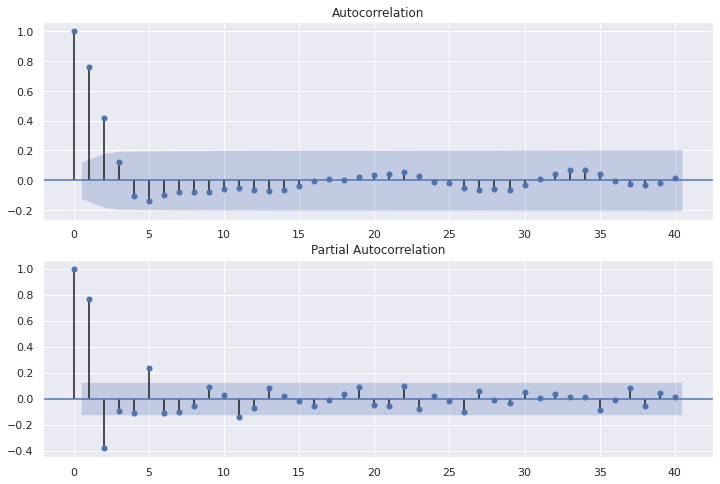

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df1['ninety_days_return'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df1['ninety_days_return'],lags=40,ax=ax2)

###Splitting the dataset into Training and Testing

In [ ]:
train = df1.iloc[:209]
test = df1.iloc[209:]

###Building AR model

In [ ]:
model_ar = AutoReg(train['ninety_days_return'], lags= 2)
model_ar = model_ar.fit()
model_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:     ninety_days_return   No. Observations:                  209
Model:                     AutoReg(2)   Log Likelihood                -792.009
Method:               Conditional MLE   S.D. of innovations             11.103
Date:                Sat, 07 Aug 2021   AIC                              4.853
Time:                        06:01:53   BIC                              4.917
Sample:                    10-31-2000   HQIC                             4.879
                         - 12-31-2017                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                 1.1026      0.786      1.402      0.161      -0.439       2.644
ninety_days_return.L1     1.1174      0.064     17.348      0.000       0.991       1.244
ninety_days_return.L2    -0.3770      0.064     -5.864      0.000      -0.503      -0.251
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4820           -0.6754j            1.6287           -0.0681
AR.2            1.4820           +0.6754j            1.6287            0.0681
-----------------------------------------------------------------------------
"""

###Making predictions on test set

In [ ]:
pred_ar=model_ar.predict(start = len(train), end= len(train)+len(test)-1, dynamic= False)
pred_ar.index = test.index

In [ ]:
pred_ar

Date
2018-01-31    16.569277
2018-02-28    12.740990
2018-03-31     9.093162
2018-04-30     6.460239
2018-05-31     4.893361
2018-06-30     4.135092
2018-07-31     3.878490
2018-08-31     3.877618
2018-09-30     3.973383
2018-10-31     4.080720
2018-11-30     4.164559
2018-12-31     4.217776
2019-01-31     4.245636
2019-02-28     4.256705
2019-03-31     4.258570
2019-04-30     4.256482
2019-05-31     4.253445
2019-06-30     4.250839
2019-07-31     4.249071
2019-08-31     4.248079
2019-09-30     4.247636
2019-10-31     4.247516
2019-11-30     4.247548
2019-12-31     4.247630
2020-01-31     4.247708
2020-02-29     4.247766
2020-03-31     4.247800
2020-04-30     4.247817
2020-05-31     4.247823
2020-06-30     4.247823
2020-07-31     4.247821
2020-08-31     4.247819
2020-09-30     4.247817
2020-10-31     4.247816
2020-11-30     4.247815
2020-12-31     4.247815
2021-01-31     4.247815
2021-02-28     4.247815
2021-03-31     4.247815
Freq: M, dtype: float64

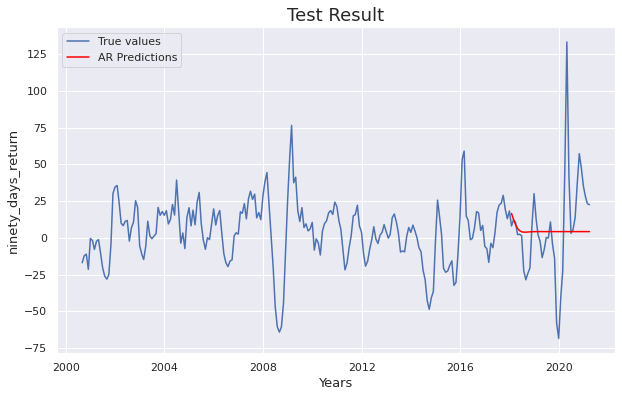

In [ ]:
plt.figure(figsize=(10,6));
plt.plot(df1['ninety_days_return'],label="True values");
plt.plot(pred_ar,color='red',label='AR Predictions');
plt.xlabel('Years', fontsize= 13);
plt.ylabel('ninety_days_return', fontsize= 13);
plt.title('Test Result', fontsize= 18);
plt.legend();

###Error Metric

In [ ]:
mse = mean_squared_error(pred_ar,test['ninety_days_return'])
rmse = sqrt(mean_squared_error(pred_ar,test['ninety_days_return']))
print('Mean squared value :',round(mse,2))
print('Root mean squared value :',round(rmse,2))

Mean squared value : 1146.14
Root mean squared value : 33.85


###Cross validation

In [ ]:
x, y = split_train_variableInput(df1['ninety_days_return'], minSamplesTrain= 48, numOutputs= 6, numJumps= 12)

In [ ]:
def show_train(X, y, num):
    for j in np.arange(num):
        print("--------- SET %d ---------" % (j+1))
        print("X[%d] ="% (j+1), X[j])
        print("y[%d] ="% (j+1), y[j])

In [ ]:
show_train(x,y,1)

--------- SET 1 ---------
X[1] = Date
2000-08-31   -16.940757
2000-09-30   -12.200819
2000-10-31   -11.056277
2000-11-30   -21.385323
2000-12-31    -0.414529
2001-01-31    -1.852070
2001-02-28    -7.864715
2001-03-31    -2.280355
2001-04-30    -1.204533
2001-05-31   -10.638391
2001-06-30   -20.408505
2001-07-31   -26.045727
2001-08-31   -28.109630
2001-09-30   -24.951525
2001-10-31    -4.660265
2001-11-30    30.176505
2001-12-31    34.599257
2002-01-31    35.586243
2002-02-28    24.615860
2002-03-31    10.018419
2002-04-30     8.266086
2002-05-31    11.262683
2002-06-30    11.818695
2002-07-31    -2.206774
2002-08-31     6.945864
2002-09-30    10.601895
2002-10-31    25.238696
2002-11-30    20.829567
2002-12-31    -5.415268
2003-01-31   -11.084152
2003-02-28   -14.736215
2003-03-31    -5.695348
2003-04-30    11.310159
2003-05-31     1.346777
2003-06-30    -0.569286
2003-07-31     1.153213
2003-08-31     2.919786
2003-09-30    20.696095
2003-10-31    15.367248
2003-11-30    17.902445
20

In [ ]:
def cross_validation_score_AR(model, x, y, metric):
    import warnings
    warnings.filterwarnings("ignore")
    
    cv_scores_rmse = []
    for cv_train, cv_test in zip(x,y):
        model = AutoReg(cv_train, lags= 2)
        model = model.fit()
        pred = model.predict(start = len(cv_train), end= len(cv_train)+len(cv_test)-1, dynamic= False)
        score = sqrt(metric(y_true = cv_test, y_pred = pred))
        cv_scores_rmse.append(round(score,2))
    return cv_scores_rmse

def ar_result(x):
    print("AR cross validation score - ")
    print('cv_scores_rmse: ', x)
    print('Maximum rmse score: ', max(x))
    print('Minimum rmse score: ', min(x))
    print("Average_rmse_score: ", round(np.mean(x),2))

In [ ]:
res_ar = cross_validation_score_AR(model= AutoReg, x= x, y= y, metric= mean_squared_error)

In [ ]:
ar_result(res_ar)

AR cross validation score - 
cv_scores_rmse:  [10.32, 6.93, 7.1, 15.77, 29.99, 10.19, 10.5, 10.92, 3.49, 3.33, 27.6, 26.98, 8.23, 9.9, 14.39, 43.36, 35.01]
Maximum rmse score:  43.36
Minimum rmse score:  3.33
Average_rmse_score:  16.12


###Future Forecasting for next 7 months-

In [ ]:
model_ar_f = AutoReg(df1['ninety_days_return'], lags= 2)
model_ar_f = model_ar_f.fit()

In [ ]:
index_future_dates = pd.bdate_range(start='2021-03-02',end='2021-10-01', freq='M')
forecast_ar = model_ar_f.predict(start= len(df1), end= len(df1)+7-1).rename('AR Forecast')
forecast_ar.index = index_future_dates
forecast_ar = pd.DataFrame(forecast_ar, index = forecast_ar.index)
forecast_ar

AR Forecast
2021-03-31    16.373910
2021-04-30    10.189898
2021-05-31     6.023140
2021-06-30     3.982622
2021-07-31     3.412921
2021-08-31     3.584872
2021-09-30     3.980358

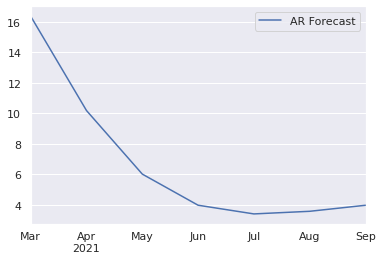

In [ ]:
forecast_ar.plot(legend= 'AR Forecast');

##ARIMA Algorithm (Auto Regression Integrated Moving Average)

###Building ARIMA model.

In [ ]:
model_arima = pm.auto_arima(df1['ninety_days_return'], seasonal=True, start_p=0, start_q=0, test='adf',
                            error_action='ignore', suppress_warnings=True, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2265.463, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2052.322, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2081.614, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2272.051, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2016.500, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2016.430, Time=0.23 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=2015.967, Time=0.28 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=2005.131, Time=0.36 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=2005.869, Time=0.52 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=2009.869, Time=0.35 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=2005.442, Time=0.15 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
Total fit time: 2.240 seconds


In [ ]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  248
Model:               SARIMAX(5, 0, 0)   Log Likelihood                -995.565
Date:                Sat, 07 Aug 2021   AIC                           2005.131
Time:                        06:01:56   BIC                           2029.725
Sample:                             0   HQIC                          2015.031
                                - 248                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3321      0.973      1.369      0.171      -0.575       3.240
ar.L1          1.0267      0.049     21.027      0.000       0.931       1.122
ar.L2         -0.3091      0.081     -3.808      0.000      -0.468      -0.150
ar.L3          0.0796      0.068      1.166      0.244      -0.054       0.214
ar.L4         -0.3257      0.057     -5.665      0.000      -0.438      -0.213
ar.L5          0.2261      0.067      3.378      0.001       0.095       0.357
sigma2       178.5513      9.178     19.454      0.000     160.562     196.541
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               580.42
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               3.13   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model_arima.fit(train['ninety_days_return'])

ARIMA(maxiter=50, method='lbfgs', order=(5, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

###Making predictions on the test dataset

In [ ]:
pred_test_arima = model_arima.predict(n_periods= len(test))
pred_test_arima

array([12.70786599, 11.4298544 ,  9.56974349,  5.70058313,  4.78130382,
        3.59310316,  3.24255802,  3.82245932,  4.0407038 ,  4.40919704,
        4.53510678,  4.36161166,  4.18523645,  3.94262078,  3.77544537,
        3.72543812,  3.73466137,  3.80302944,  3.8751005 ,  3.92046783,
        3.93824354,  3.92516006,  3.89804833,  3.87137066,  3.85271164,
        3.84709823,  3.85152748,  3.86092797,  3.87059337,  3.87671553,
        3.87842143,  3.87658869,  3.87297297,  3.86950376,  3.86732485,
        3.86676812,  3.86749872,  3.86881201,  3.87005419])

In [ ]:
forecast_test = pd.DataFrame(pred_test_arima, index = test.index, columns= ['Prediction'])
forecast_test

Prediction
Date                  
2018-01-31   12.707866
2018-02-28   11.429854
2018-03-31    9.569743
2018-04-30    5.700583
2018-05-31    4.781304
2018-06-30    3.593103
2018-07-31    3.242558
2018-08-31    3.822459
2018-09-30    4.040704
2018-10-31    4.409197
2018-11-30    4.535107
2018-12-31    4.361612
2019-01-31    4.185236
2019-02-28    3.942621
2019-03-31    3.775445
2019-04-30    3.725438
2019-05-31    3.734661
2019-06-30    3.803029
2019-07-31    3.875100
2019-08-31    3.920468
2019-09-30    3.938244
2019-10-31    3.925160
2019-11-30    3.898048
2019-12-31    3.871371
2020-01-31    3.852712
2020-02-29    3.847098
2020-03-31    3.851527
2020-04-30    3.860928
2020-05-31    3.870593
2020-06-30    3.876716
2020-07-31    3.878421
2020-08-31    3.876589
2020-09-30    3.872973
2020-10-31    3.869504
2020-11-30    3.867325
2020-12-31    3.866768
2021-01-31    3.867499
2021-02-28    3.868812
2021-03-31    3.870054

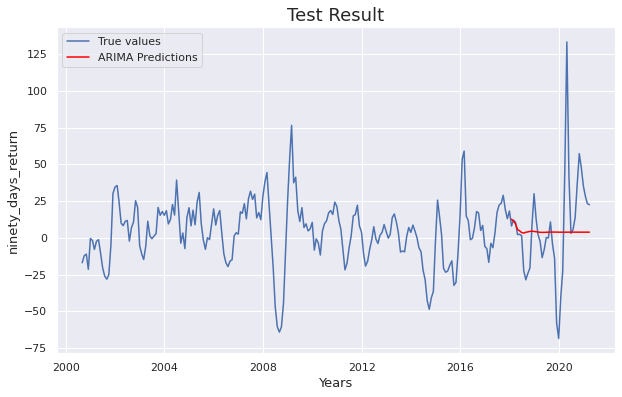

In [ ]:
plt.figure(figsize=(10,6));
plt.plot(df1['ninety_days_return'],label="True values");
plt.plot(forecast_test,color='red',label='ARIMA Predictions');
plt.xlabel('Years', fontsize= 13);
plt.ylabel('ninety_days_return', fontsize= 13);
plt.title('Test Result', fontsize= 18);
plt.legend();

###Error Metric

In [ ]:
mse = mean_squared_error(forecast_test,test['ninety_days_return'])
rmse = sqrt(mean_squared_error(forecast_test,test['ninety_days_return']))
print('Mean squared value :',round(mse,2))
print('Root mean squared value :',round(rmse,2))

Mean squared value : 1147.16
Root mean squared value : 33.87


###Cross-Validation

In [ ]:
show_train(x,y,2)

--------- SET 1 ---------
X[1] = Date
2000-08-31   -16.940757
2000-09-30   -12.200819
2000-10-31   -11.056277
2000-11-30   -21.385323
2000-12-31    -0.414529
2001-01-31    -1.852070
2001-02-28    -7.864715
2001-03-31    -2.280355
2001-04-30    -1.204533
2001-05-31   -10.638391
2001-06-30   -20.408505
2001-07-31   -26.045727
2001-08-31   -28.109630
2001-09-30   -24.951525
2001-10-31    -4.660265
2001-11-30    30.176505
2001-12-31    34.599257
2002-01-31    35.586243
2002-02-28    24.615860
2002-03-31    10.018419
2002-04-30     8.266086
2002-05-31    11.262683
2002-06-30    11.818695
2002-07-31    -2.206774
2002-08-31     6.945864
2002-09-30    10.601895
2002-10-31    25.238696
2002-11-30    20.829567
2002-12-31    -5.415268
2003-01-31   -11.084152
2003-02-28   -14.736215
2003-03-31    -5.695348
2003-04-30    11.310159
2003-05-31     1.346777
2003-06-30    -0.569286
2003-07-31     1.153213
2003-08-31     2.919786
2003-09-30    20.696095
2003-10-31    15.367248
2003-11-30    17.902445
20

In [ ]:
def cross_validation_score_ARIMA(model, x, y, metric):
    import warnings
    warnings.filterwarnings("ignore")
    
    cv_scores_rmse = []
    for cv_train, cv_test in zip(x,y):
        m_arima = model.fit(cv_train)
        pred = m_arima.predict(n_periods= len(cv_test))
        score = sqrt(metric(y_true = cv_test, y_pred = pred))
        cv_scores_rmse.append(round(score,2))
    return cv_scores_rmse

def arima_result(x):
    print("ARIMA cross validation score - ")
    print('cv_scores_rmse: ', x)
    print('Maximum rmse score: ', max(x))
    print('Minimum rmse score: ', min(x))
    print("Average_rmse_score: ", round(np.mean(x),2))

In [ ]:
res_arima = cross_validation_score_ARIMA(model= model_arima, x= x, y= y, metric= mean_squared_error)

In [ ]:
arima_result(res_arima)

ARIMA cross validation score - 
cv_scores_rmse:  [9.46, 5.3, 10.0, 15.45, 28.28, 8.14, 10.96, 8.33, 4.6, 4.55, 27.73, 29.97, 8.27, 11.11, 12.56, 43.11, 45.77]
Maximum rmse score:  45.77
Minimum rmse score:  4.55
Average_rmse_score:  16.68


###Future Forecasting for next 7 months-

In [ ]:
model_f = model_arima.fit(df1['ninety_days_return'])

In [ ]:
index_future_dates = pd.bdate_range(start='2021-03-02',end='2021-10-01', freq='M')
forecast_arima = model_f.predict(n_periods= 7)
forecast_arima = pd.DataFrame(forecast_arima, index = index_future_dates, columns= ['ARIMA Forecast'])
forecast_arima

ARIMA Forecast
2021-03-31       18.819327
2021-04-30       14.414886
2021-05-31       10.836185
2021-06-30        7.426798
2021-07-31        5.721948
2021-08-31        5.334705
2021-09-30        5.362230

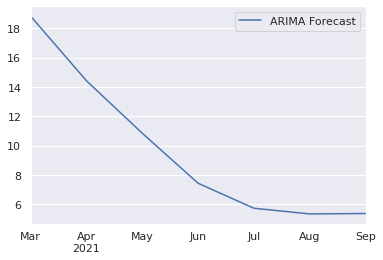

In [ ]:
forecast_arima.plot();

##FbProphet

In [ ]:
df_fb = df1.copy()
df_fb['Date'] = df_fb.index
df_fb.reset_index(drop=True, inplace=True)
df_fb = df_fb[['Date', 'ninety_days_return']]
df_fb.head()

Date  ninety_days_return
0 2000-08-31          -16.940757
1 2000-09-30          -12.200819
2 2000-10-31          -11.056277
3 2000-11-30          -21.385323
4 2000-12-31           -0.414529

###Renaming the columns as per FbProphet requirements

In [ ]:
df_fb.columns = ['ds','y']
df_fb.head()

ds          y
0 2000-08-31 -16.940757
1 2000-09-30 -12.200819
2 2000-10-31 -11.056277
3 2000-11-30 -21.385323
4 2000-12-31  -0.414529

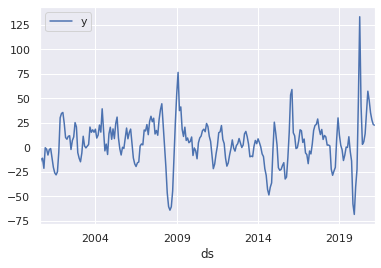

In [ ]:
df_fb.plot(x='ds');

###Train - Test split

In [ ]:
train = df_fb.iloc[:209]
test = df_fb.iloc[209:]

###Initialising the Model 

In [ ]:
model_train = Prophet()
model_train.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


###Test data predictions

In [ ]:
test_dates = model_train.make_future_dataframe(periods= len(test), freq= 'M')

In [ ]:
pred_test = model_train.predict(test_dates)
pred_test[['ds', 'yhat']]

ds       yhat
0   2000-08-31  -3.705480
1   2000-09-30  -1.951330
2   2000-10-31   0.862395
3   2000-11-30   7.377411
4   2000-12-31  13.100390
..         ...        ...
243 2020-11-30   3.973865
244 2020-12-31   9.696743
245 2021-01-31  11.598264
246 2021-02-28  11.717778
247 2021-03-31   5.147634

[248 rows x 2 columns]

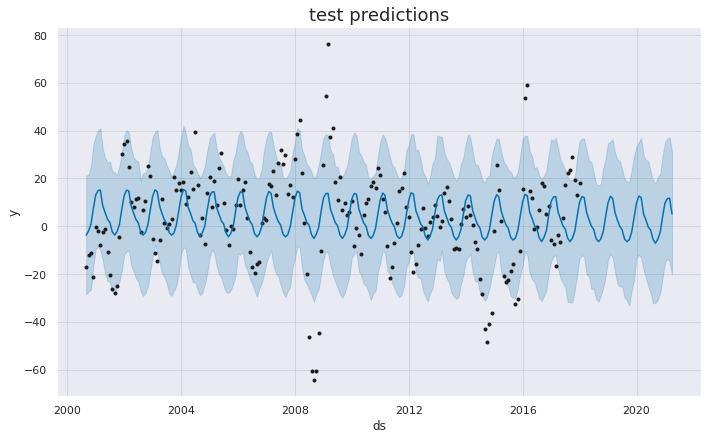

In [ ]:
# Plotting the predictions
model_train.plot(pred_test, figsize=(10,6));
plt.title('test predictions',fontsize= 18);

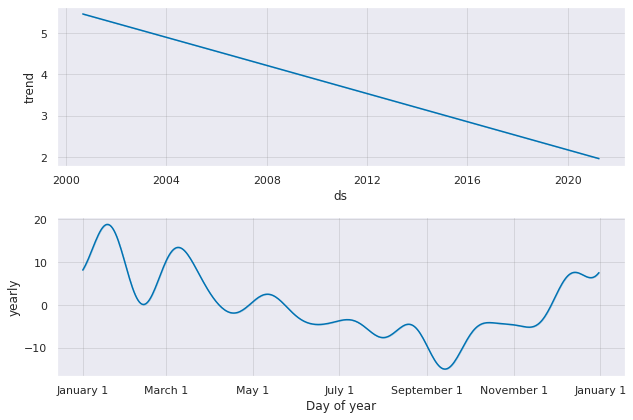

In [ ]:
#Visualize Each Components[Trends,yearly]
model_train.plot_components(pred_test);

###Error Metric

In [ ]:
mse = mean_squared_error(test['y'], pred_test['yhat'][209:])
rmse = sqrt(mse)
print('Mean squared error :', round(mse,2))
print('Root mean squared error :', round(rmse,2))

Mean squared error : 1191.35
Root mean squared error : 34.52


###Cross-Validation

In [ ]:
p,q = split_train_variableInput(df_fb, minSamplesTrain= 48, numOutputs= 6, numJumps= 12)

In [ ]:
show_train(p,q,1)

--------- SET 1 ---------
X[1] =            ds          y
0  2000-08-31 -16.940757
1  2000-09-30 -12.200819
2  2000-10-31 -11.056277
3  2000-11-30 -21.385323
4  2000-12-31  -0.414529
5  2001-01-31  -1.852070
6  2001-02-28  -7.864715
7  2001-03-31  -2.280355
8  2001-04-30  -1.204533
9  2001-05-31 -10.638391
10 2001-06-30 -20.408505
11 2001-07-31 -26.045727
12 2001-08-31 -28.109630
13 2001-09-30 -24.951525
14 2001-10-31  -4.660265
15 2001-11-30  30.176505
16 2001-12-31  34.599257
17 2002-01-31  35.586243
18 2002-02-28  24.615860
19 2002-03-31  10.018419
20 2002-04-30   8.266086
21 2002-05-31  11.262683
22 2002-06-30  11.818695
23 2002-07-31  -2.206774
24 2002-08-31   6.945864
25 2002-09-30  10.601895
26 2002-10-31  25.238696
27 2002-11-30  20.829567
28 2002-12-31  -5.415268
29 2003-01-31 -11.084152
30 2003-02-28 -14.736215
31 2003-03-31  -5.695348
32 2003-04-30  11.310159
33 2003-05-31   1.346777
34 2003-06-30  -0.569286
35 2003-07-31   1.153213
36 2003-08-31   2.919786
37 2003-09-30  20

In [ ]:
def cross_validation_score_fb(model, x, y, metric):
    import warnings
    warnings.filterwarnings("ignore")
    
    cv_rmse_fb = []
    for cv_train, cv_test in zip(p,q):
        objs = [model() for i in range(17)]
        for obj in objs:
            modelf = obj
            modelf.fit(cv_train)
            test_cv_dates = modelf.make_future_dataframe(periods= len(cv_test), freq= 'M')
            pred_test_cv = modelf.predict(test_cv_dates)
            mse = metric(cv_test['y'], pred_test_cv['yhat'][len(cv_train):])
            rmse = sqrt(mse)
            cv_rmse_fb.append(round(rmse,2))
            break
    return cv_rmse_fb 
          
def fb_result(x):
    print("FbProphet cross validation score - ")
    print('cv_scores_rmse: ', x)
    print('Maximum rmse score: ', max(x))
    print('Minimum rmse score: ', min(x))
    print("Average_rmse_score: ", round(np.mean(x),2))

In [ ]:
res_fb = cross_validation_score_fb(model= Prophet, x= p, y= q, metric = mean_squared_error)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:
fb_result(res_fb)

FbProphet cross validation score - 
cv_scores_rmse:  [20.74, 15.89, 16.28, 16.48, 50.02, 16.48, 13.35, 18.35, 8.37, 7.04, 34.93, 23.92, 19.98, 23.13, 16.13, 46.45, 40.02]
Maximum rmse score:  50.02
Minimum rmse score:  7.04
Average_rmse_score:  22.8


###Future Forecasting - 7 Months

In [ ]:
model = Prophet()
model.fit(df_fb)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future_dates = model.make_future_dataframe(periods=7, freq= 'M')

In [ ]:
forecast = model.predict(future_dates)

In [ ]:
forecast[['ds', 'yhat']][len(df_fb):]

ds       yhat
248 2021-04-30  10.399153
249 2021-05-31   3.152252
250 2021-06-30   0.277476
251 2021-07-31  -4.055588
252 2021-08-31  -4.652637
253 2021-09-30  -2.640845
254 2021-10-31   0.630751

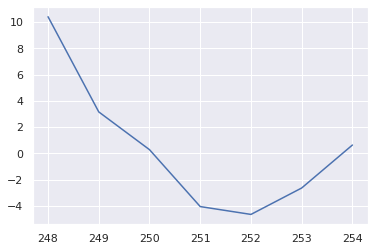

In [ ]:
forecast['yhat'][len(df_fb):].plot();

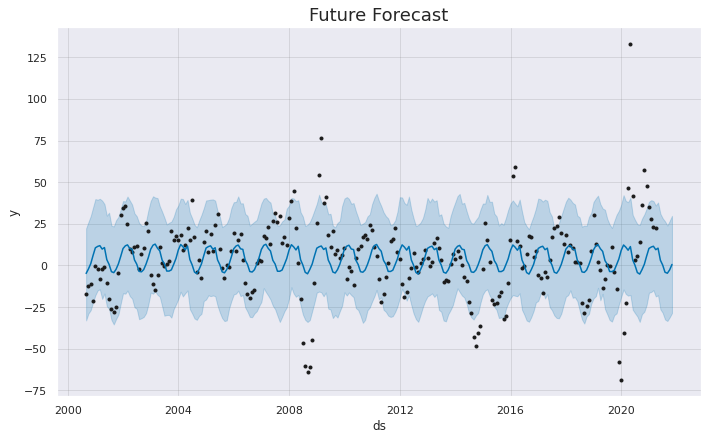

In [ ]:
# Plotting the forecast
model.plot(forecast, figsize=(10,6));
plt.title('Future Forecast',fontsize= 18);

##Linear Regression

###Importing Dataset

In [ ]:
data = pd.read_excel('New_Crude_All_manipulated.xlsx', sheet_name= 'Data', 
                     usecols= ['Date', 'Close','ninety_days_return','Prev_quarter_GDP_PCH', 'Prev_quarter_inflation_rate', 'Prev_quarter_WTI_price_PCH'])

data.Date = pd.to_datetime(data.Date)
data['month_no'] = pd.DatetimeIndex(data['Date']).month
data['week_no'] = pd.DatetimeIndex(data['Date']).week
data.head()

Date      Close  ...  month_no  week_no
0 2000-08-23  32.049999  ...         8       34
1 2000-08-24  31.629999  ...         8       34
2 2000-08-25  32.049999  ...         8       34
3 2000-08-28  32.869999  ...         8       35
4 2000-08-29  32.720001  ...         8       35

[5 rows x 8 columns]

In [ ]:
data.set_index(data.Date, inplace= True)

In [ ]:
data = data.resample('M').mean()
data.head()

Close  ninety_days_return  ...  month_no    week_no
Date                                       ...                     
2000-08-31  32.545714          -17.607382  ...       8.0  34.571429
2000-09-30  33.847619          -12.668322  ...       9.0  37.380952
2000-10-31  32.973182          -10.658361  ...      10.0  41.727273
2000-11-30  34.367728          -21.237864  ...      11.0  46.090909
2000-12-31  28.251428           -0.620891  ...      12.0  50.380952

[5 rows x 7 columns]

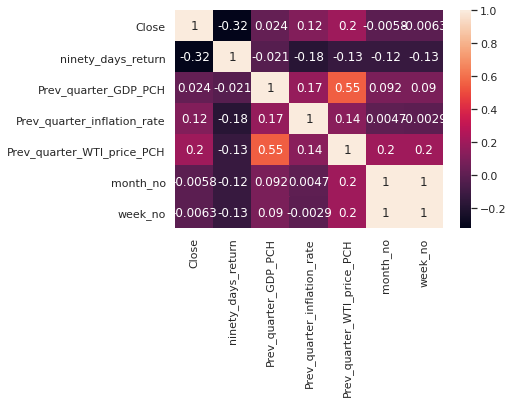

In [ ]:
corr = data.corr()
sns.heatmap(corr, annot= True);
plt.show();

Here, there is strong correlation between month_no & week_no. Hence, either one of them can be used in model building.

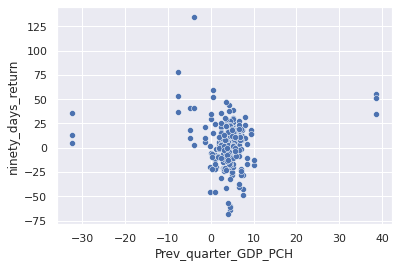

In [ ]:
sns.scatterplot(x= 'Prev_quarter_GDP_PCH', y= 'ninety_days_return', data= data);

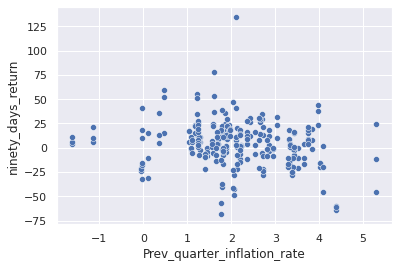

In [ ]:
sns.scatterplot(x= 'Prev_quarter_inflation_rate', y= 'ninety_days_return', data= data);

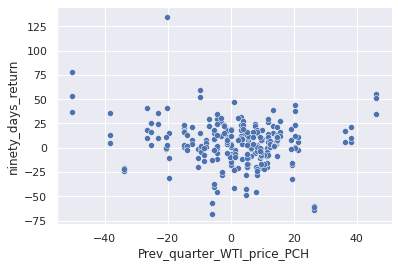

In [ ]:
sns.scatterplot(x= 'Prev_quarter_WTI_price_PCH', y= 'ninety_days_return', data= data);

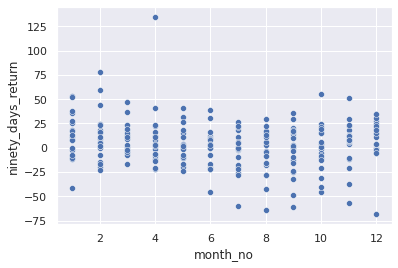

In [ ]:
sns.scatterplot(x= 'month_no', y= 'ninety_days_return', data= data);

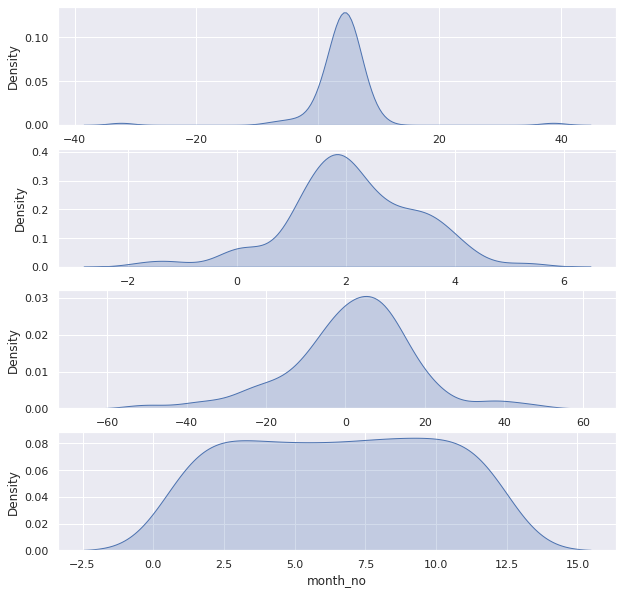

In [ ]:
fig, axs = plt.subplots(nrows= 4);
fig.set_size_inches(10,10);
sns.kdeplot(data['Prev_quarter_GDP_PCH'], shade=True, ax= axs[0]);
sns.kdeplot(data['Prev_quarter_inflation_rate'], shade=True, ax= axs[1]);
sns.kdeplot(data['Prev_quarter_WTI_price_PCH'], shade=True, ax= axs[2]);
sns.kdeplot(data['month_no'], shade=True, ax= axs[3]);

###Assigning the Independent & Dependent feature-

In [ ]:
x = data.iloc[:, [2,3,4,5]].values
y = data.iloc[:, 1].values.reshape(-1,1)

###Train-Test Split

In [ ]:
x_train, x_test, y_train, y_test = x[:209], x[209:], y[:209], y[209:] 

###Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train) 
x_test = sc.transform(x_test)

###Training on linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

###Predicting on Test set

In [ ]:
y_pred = regressor.predict(x_test)

###Error Metric

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test,y_pred)
rmse = sqrt(mse)
print('Mean squared error :', round(mse,2))
print('Root mean squared error :', round(rmse,2))

Mean squared error : 1369.2
Root mean squared error : 37.0


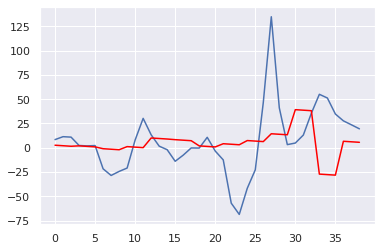

In [ ]:
plt.plot(y_test, label= "True values");
plt.plot(y_pred, color ='red', label= "Test Predictions");
plt.title('Linear Regression - Test Predictions');
plt.legend();

###Cross Validation

In [ ]:
a,b = split_train_variableInput(data, minSamplesTrain= 48, numOutputs= 6, numJumps= 12)

In [ ]:
show_train(a,b,1)

--------- SET 1 ---------
X[1] =                 Close  ninety_days_return  ...  month_no    week_no
Date                                       ...                     
2000-08-31  32.545714          -17.607382  ...       8.0  34.571429
2000-09-30  33.847619          -12.668322  ...       9.0  37.380952
2000-10-31  32.973182          -10.658361  ...      10.0  41.727273
2000-11-30  34.367728          -21.237864  ...      11.0  46.090909
2000-12-31  28.251428           -0.620891  ...      12.0  50.380952
2001-01-31  29.193478           -1.760387  ...       1.0   2.826087
2001-02-28  29.620000           -7.610891  ...       2.0   7.100000
2001-03-31  27.263182           -2.533542  ...       3.0  11.272727
2001-04-30  27.654286           -1.138726  ...       4.0  15.619048
2001-05-31  28.670869           -9.979963  ...       5.0  20.000000
2001-06-30  27.588095          -19.975238  ...       6.0  24.380952
2001-07-31  26.456818          -25.959371  ...       7.0  28.727273
2001-08-31  27.

In [ ]:
def cross_validation_score_LR(model, x, y, metric):
    cv_scores_rmse = []
    for cv_train, cv_test in zip(x,y):
        X_train = cv_train.iloc[:, [2,3,4,5]].values
        Y_train = cv_train.iloc[:, 1].values
        reg = model
        reg.fit(X_train, Y_train)
        X_test = cv_test.iloc[:, [2,3,4,5]].values
        Y_test = cv_test.iloc[:, 1].values
        Y_pred = reg.predict(X_test)
        score = sqrt(metric(y_true = Y_test, y_pred = Y_pred))
        cv_scores_rmse.append(round(score,2))
    return cv_scores_rmse

def lr_result(x):
    print("Linear Regression cross validation score - ")
    print('cv_scores_rmse: ', x)
    print('Maximum rmse score: ', max(x))
    print('Minimum rmse score: ', min(x))
    print("Average_rmse_score: ", round(np.mean(x),2))

In [ ]:
res_lr = cross_validation_score_LR(model= LinearRegression(), x=a, y=b, metric= mean_squared_error)

In [ ]:
lr_result(res_lr)

Linear Regression cross validation score - 
cv_scores_rmse:  [13.28, 14.4, 6.18, 23.39, 43.28, 25.96, 5.49, 13.37, 12.48, 13.24, 43.72, 30.62, 13.04, 17.35, 21.17, 43.58, 56.7]
Maximum rmse score:  56.7
Minimum rmse score:  5.49
Average_rmse_score:  23.37


###Future Forecasting - 7 Months

In [ ]:
f = pd.read_excel('New_Crude_All_manipulated.xlsx', sheet_name= 'F')

f.Date = pd.to_datetime(f.Date)
f['month_no'] = pd.DatetimeIndex(f['Date']).month
f.head()

Date  Prev_quarter_GDP  ...  Prev_quarter_WTI_price  month_no
0 2021-03-03               6.6  ...                 3.99397         3
1 2021-03-04               6.6  ...                 3.99397         3
2 2021-03-05               6.6  ...                 3.99397         3
3 2021-03-08               6.6  ...                 3.99397         3
4 2021-03-09               6.6  ...                 3.99397         3

[5 rows x 5 columns]

In [ ]:
f.set_index(f.Date, inplace= True)
f = f.resample('M').mean()
f

Prev_quarter_GDP  ...  month_no
Date                          ...          
2021-03-31               6.6  ...         3
2021-04-30              10.9  ...         4
2021-05-31              10.9  ...         5
2021-06-30              10.9  ...         6
2021-07-31              13.0  ...         7
2021-08-31              13.0  ...         8
2021-09-30              13.0  ...         9

[7 rows x 4 columns]

In [ ]:
f_x = f.iloc[:, 0:].values

In [ ]:
forecast = regressor.predict(f_x)

In [ ]:
forecast = pd.DataFrame(forecast, index= f.index, columns= ['Forecast_LR'])
forecast

ninety_days_return
Date                          
2021-03-31          -28.187371
2021-04-30         -125.847437
2021-05-31         -127.679045
2021-06-30         -129.510653
2021-07-31          -84.187956
2021-08-31          -86.019564
2021-09-30          -87.851172

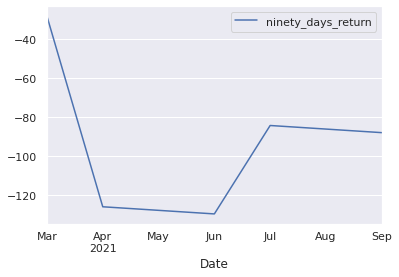

In [ ]:
forecast.plot();

#Comparing the models on the basis of cross validation result-

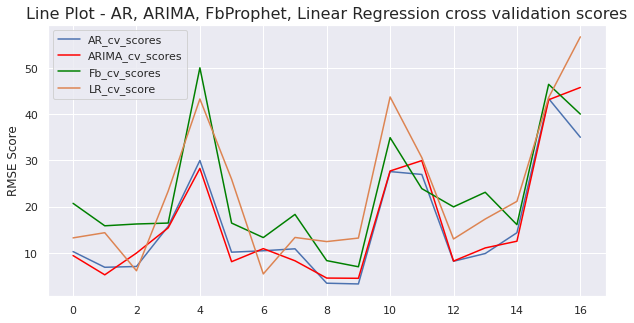

In [ ]:
fig = plt.gcf();
fig.set_size_inches(10,5);
plt.plot(res_ar, label= 'AR_cv_scores');
plt.plot(res_arima, label= 'ARIMA_cv_scores', color= 'red');
plt.plot(res_fb, label= 'Fb_cv_scores', color= 'green');
plt.plot(res_lr, label= 'LR_cv_score');
plt.legend();
plt.title('Line Plot - AR, ARIMA, FbProphet, Linear Regression cross validation scores', fontsize=16 );
plt.ylabel('RMSE Score', fontsize=12 );

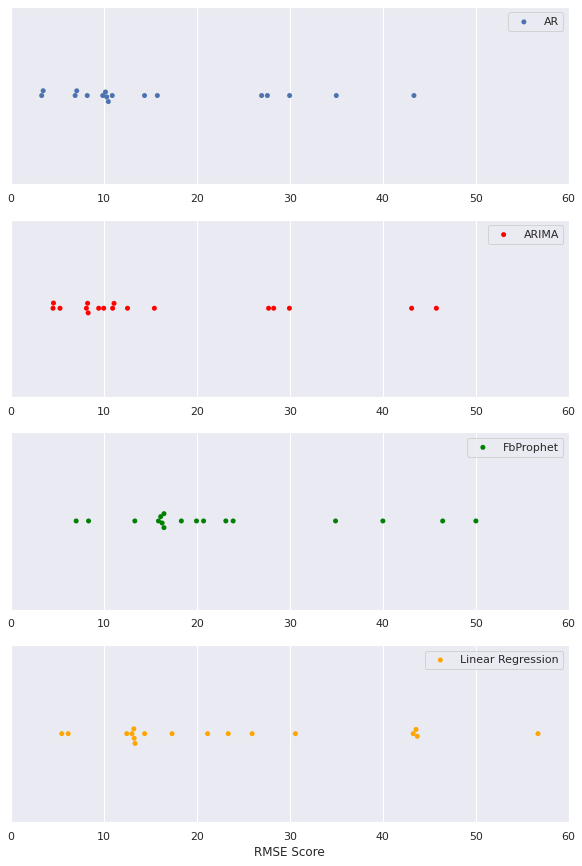

In [ ]:
fig, axs = plt.subplots(nrows= 4);
fig.set_size_inches(10,15);
p1 = sns.swarmplot(res_ar, label= 'AR', ax= axs[0]);
p1.set(xlim=(0,60));
p1.legend(labels=['AR']);
p2 = sns.swarmplot(res_arima, color = 'red', label= 'ARIMA', ax= axs[1]);
p2.set(xlim=(0,60));
p2.legend(labels=['ARIMA']);
p3 = sns.swarmplot(res_fb, color = 'green', label= 'FbProphet', ax= axs[2]);
p3.set(xlim=(0,60));
p3.legend(labels=['FbProphet']);
p4 = sns.swarmplot(res_lr,color= 'orange', label= 'Linear Regression', ax= axs[3]);
plt.xlabel('RMSE Score', fontsize=12 );
p4.set(xlim=(0,60));
p4.legend(labels=['Linear Regression']);

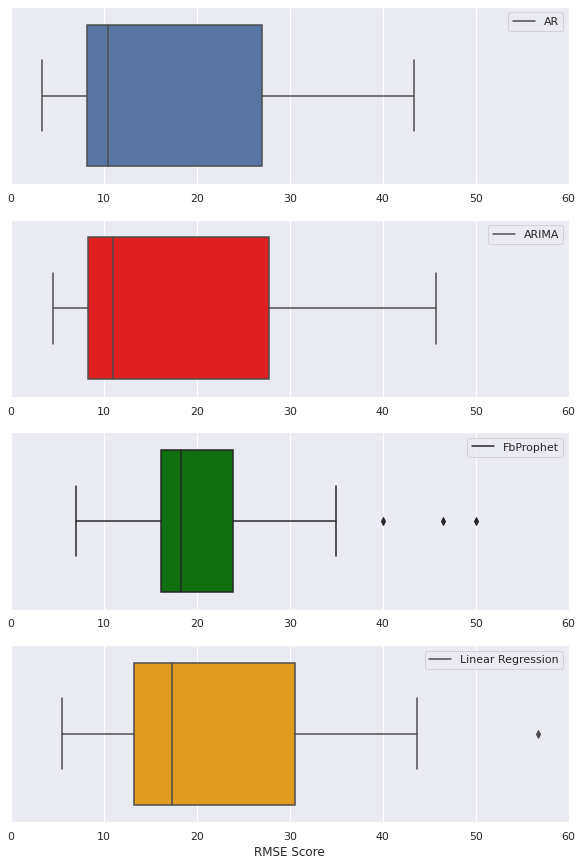

In [ ]:
fig, axs = plt.subplots(nrows= 4);
fig.set_size_inches(10,15);
p1 = sns.boxplot(res_ar, ax= axs[0], labels= ['AR']);
p1.set(xlim=(0,60));
p1.legend(labels=['AR']);
p2 = sns.boxplot(res_arima, color = 'red', ax= axs[1], labels= ['ARIMA']);
p2.set(xlim=(0,60));
p2.legend(labels=['ARIMA']);
p3 = sns.boxplot(res_fb, color = 'green', ax= axs[2], labels= ['FbProphet']);
p3.set(xlim=(0,60));
p3.legend(labels=['FbProphet']);
p4 = sns.boxplot(res_lr, color = 'orange', ax= axs[3], labels= ['Linear Regression']);
plt.xlabel('RMSE Score', fontsize=12 );
p4.set(xlim=(0,60));
p4.legend(labels=['Linear Regression']);

In [ ]:
def IQR(x):
    N = np.percentile(x,[25,75])
    IQR = round((N[1] - N[0]),2)
    print('25th quartile: ', round(N[0],2),' , ' ,'75th quartile: ', round(N[1],2))
    print('IQR: ', IQR)

In [ ]:
print('AR:')
IQR(res_ar)

AR:
25th quartile:  8.23  ,  75th quartile:  26.98
IQR:  18.75


In [ ]:
print('ARIMA:')
IQR(res_arima)

ARIMA:
25th quartile:  8.27  ,  75th quartile:  27.73
IQR:  19.46


In [ ]:
print('FbProphet:')
IQR(res_fb)

FbProphet:
25th quartile:  16.13  ,  75th quartile:  23.92
IQR:  7.79


In [ ]:
print('Linear_Regression')
IQR(res_lr)

Linear_Regression
25th quartile:  13.24  ,  75th quartile:  30.62
IQR:  17.38


#**Conclusion**

It is observed that almost all the time series models (AR, ARIMA, FbProphet) have performed somewhat similar, out of that FbProphet model cross-validation result is more consistent than the other two and linear regression. Comparing the rmse scores of cross-validation, even though it is trivial in this case, since the oil prices are highly volatile and there are some arbitrary factors which affect the oil prices such as political factor, natural catastrophe, etc. and these factors can’t be represented in the form of data for analysis. Generally, in the case of time series analysis, as we keep increasing the data for modelling, the results keep on varying and the models usually produce more accurate results when applied to a shorter period. Still, we can compare the cross-validation results and it is found that –
1.	75% of the rmse scores (cross-validation) of the AR model is ≤ 26.98.
2.	75% of the rmse scores (cross-validation) of the ARIMA model is ≤ 27.73.
3.	75% of the rmse scores (cross-validation) of the FbProphet model is ≤ 23.92.
4.	75% of the rmse scores (cross-validation) of the Linear regression model is ≤ 30.62. <br>

Hence, overall, Fbprophet model has performed better.
